# study the tail in the MC events at high Z

In [36]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm



In [37]:
# read in the thekla topological data
FOM_TS = ['456018']
TIMESTAMP = FOM_TS
RUN_NUMBER = '250925'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
# make directory
n100_dir = f'/data/halmazan/NEXT/N100_LPR_MC/{RUN_NUMBER[0]}/thekla/{FOM_TS[0]}/'
# load
hdst_local = []

for ldc in tqdm(range(1,8)):
    folder_path = f'{n100_dir}ldc{ldc}/'
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    for file in file_names:
        try:
            hdst_single = load_dst(os.path.join(folder_path, file), 'Tracking', 'Tracks')
        except Exception as e:
            print(f'Broke: {e}')
    
        hdst_local.append(hdst_single)


    print(f'Loaded!', flush = True)
hdst = pd.concat(hdst_local)
 

  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

Broke: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1652, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 632, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file '/data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc1/NEXT100_Tl208_Port1a_sophronia_873_thekla.h5'
Loaded!


 14%|█████████████████████████▏                                                                                                                                                      | 1/7 [01:12<07:15, 72.63s/it]

Broke: group ``/`` does not have a child named ``Tracking``
Loaded!


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 2/7 [02:22<05:53, 70.80s/it]

Broke: group ``/`` does not have a child named ``Tracking``
Loaded!


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 3/7 [03:29<04:36, 69.22s/it]

Broke: group ``/`` does not have a child named ``Tracking``
Broke: group ``/`` does not have a child named ``Tracking``
Broke: group ``/`` does not have a child named ``Tracking``
Broke: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1652, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 632, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file '/data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_6526_thekla.h5'
Broke: group ``/`` does not have a child named ``Tracking``
Loaded!


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 4/7 [04:42<03:31, 70.55s/it]

Loaded!


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 5/7 [05:51<02:20, 70.31s/it]

Loaded!


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6/7 [06:52<01:07, 67.05s/it]

Loaded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:53<00:00, 67.59s/it]


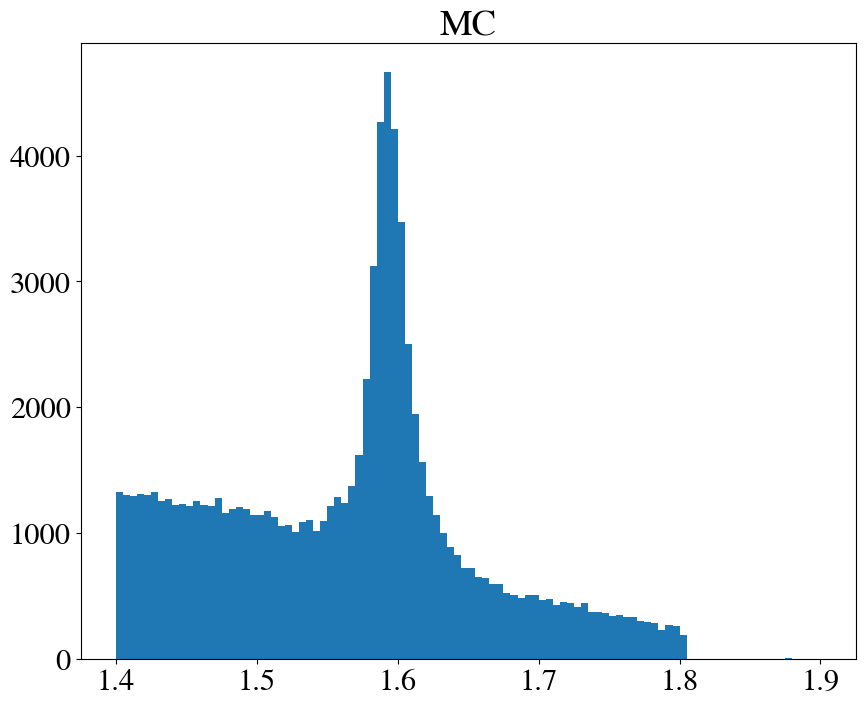

In [77]:
plt.hist(hdst.energy.values, bins = 100, range = (1.4, 1.9))
plt.title('MC')
plt.show()

In [41]:
# isolate the tail
tail_hdst = hdst[(hdst.energy > 1.62) & (hdst.energy < 1.7)]

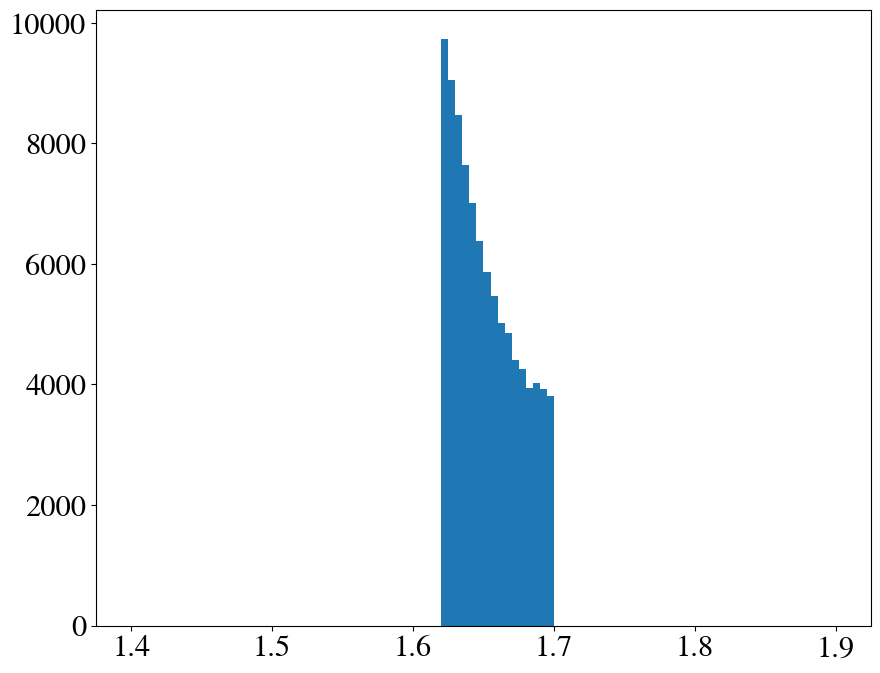

In [42]:
plt.hist(tail_hdst.energy.values, bins = 100, range = (1.4, 1.9))
plt.show()

In [43]:
print(tail_hdst.columns.values)

['event' 'trackID' 'energy' 'length' 'numb_of_voxels' 'numb_of_hits'
 'numb_of_tracks' 'x_min' 'y_min' 'z_min' 'r_min' 'x_max' 'y_max' 'z_max'
 'r_max' 'x_ave' 'y_ave' 'z_ave' 'r_ave' 'extreme1_x' 'extreme1_y'
 'extreme1_z' 'extreme2_x' 'extreme2_y' 'extreme2_z' 'blob1_x' 'blob1_y'
 'blob1_z' 'blob2_x' 'blob2_y' 'blob2_z' 'eblob1' 'eblob2'
 'ovlp_blob_energy' 'vox_size_x' 'vox_size_y' 'vox_size_z']


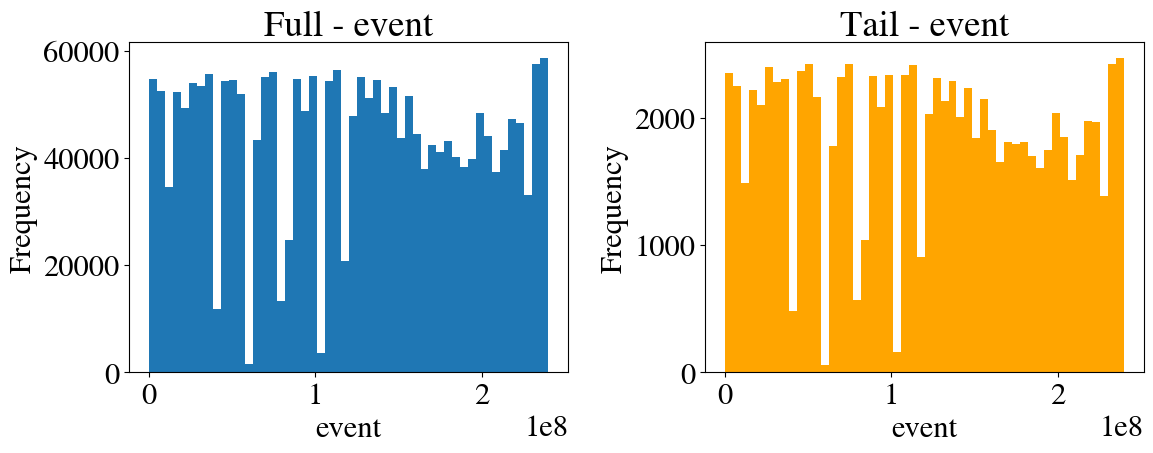

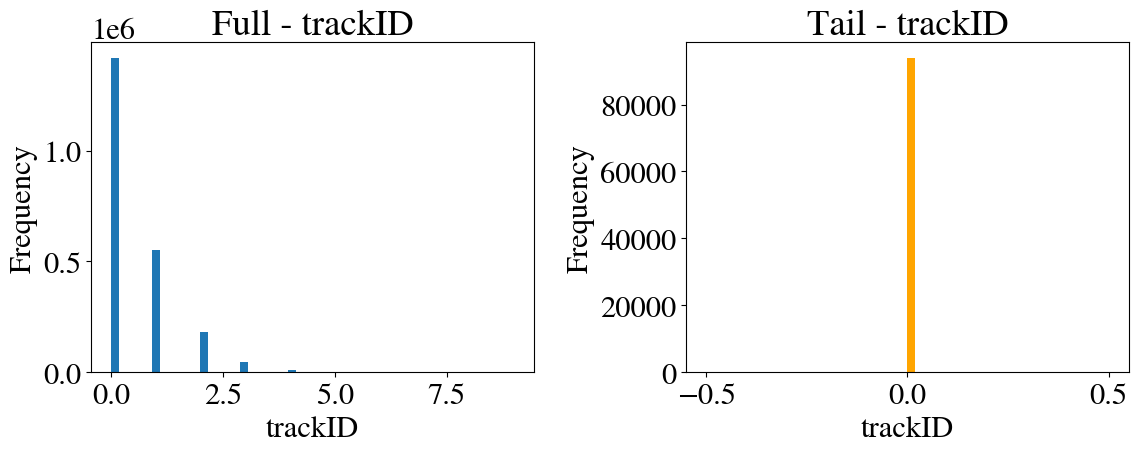

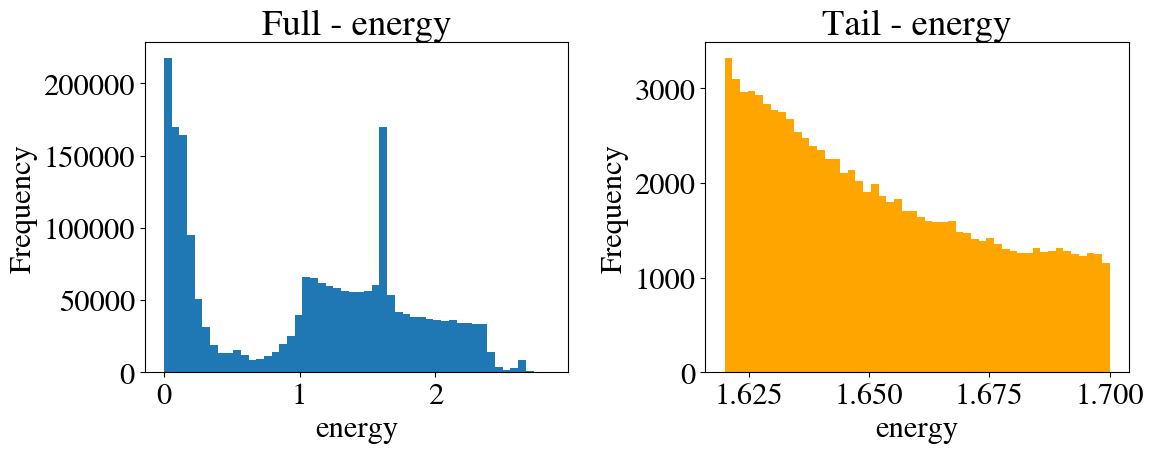

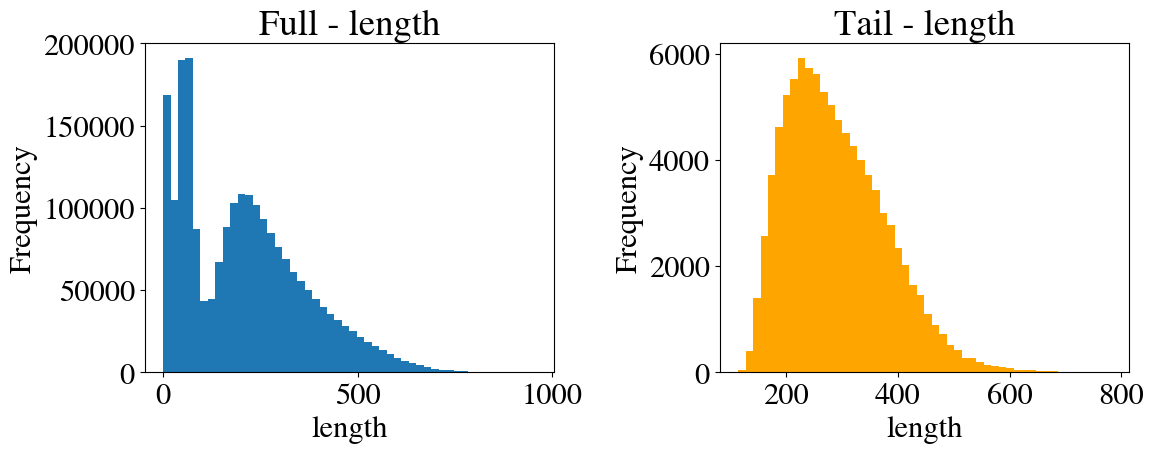

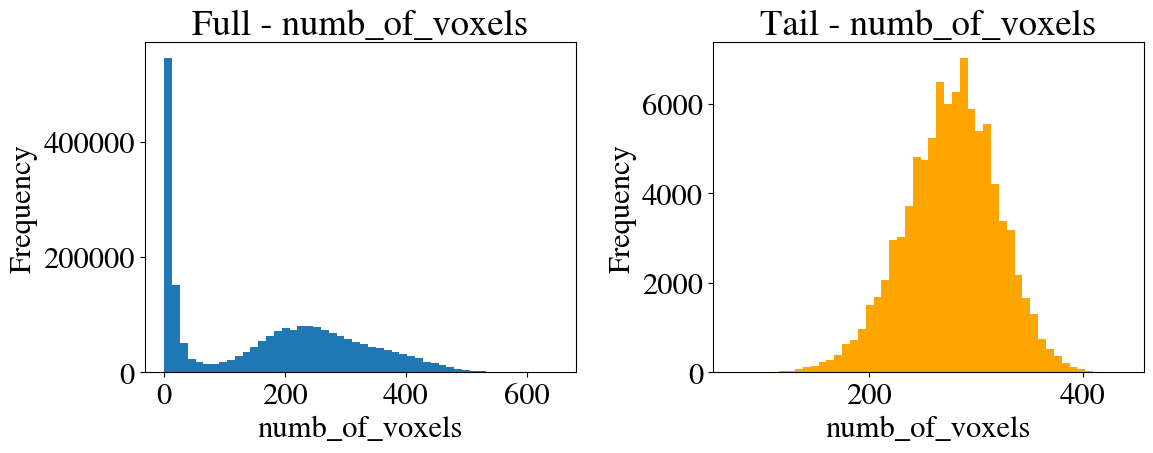

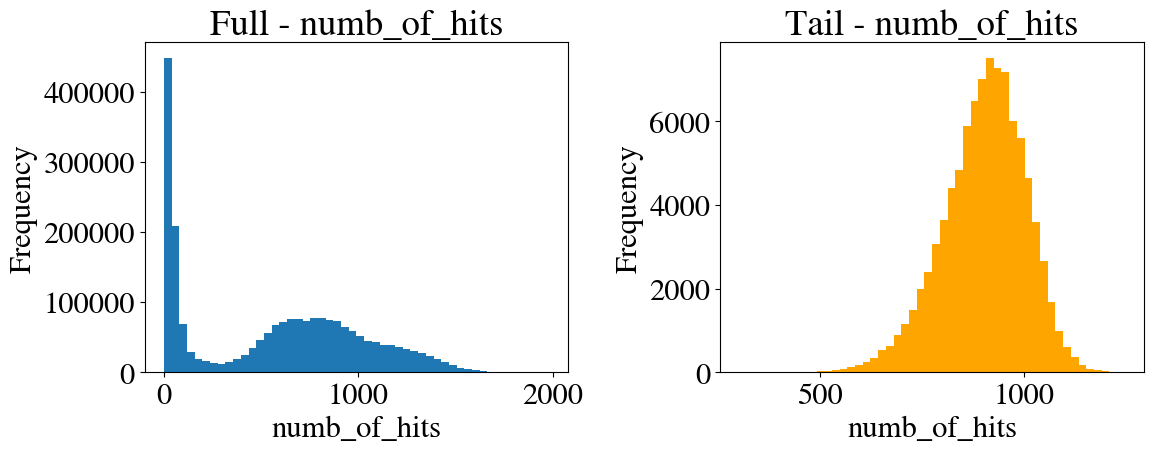

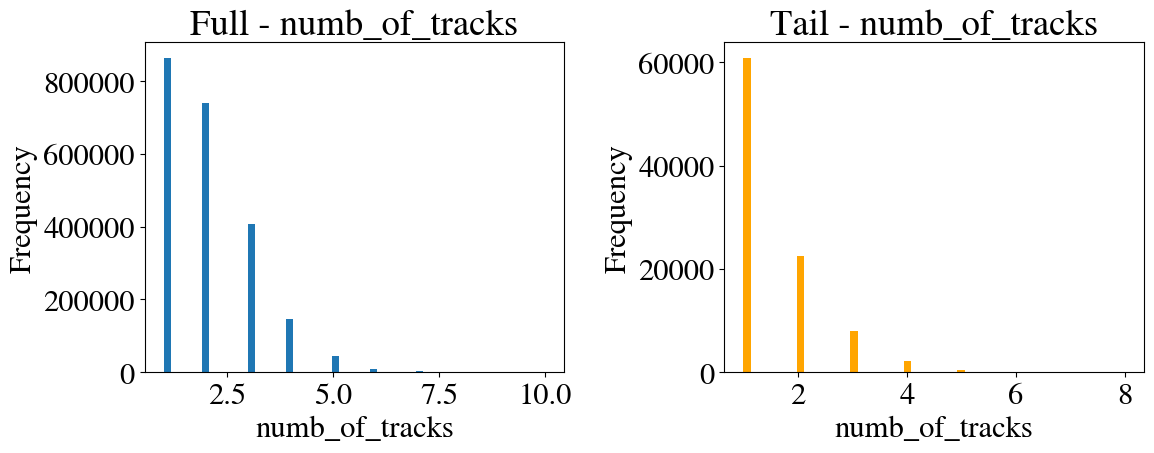

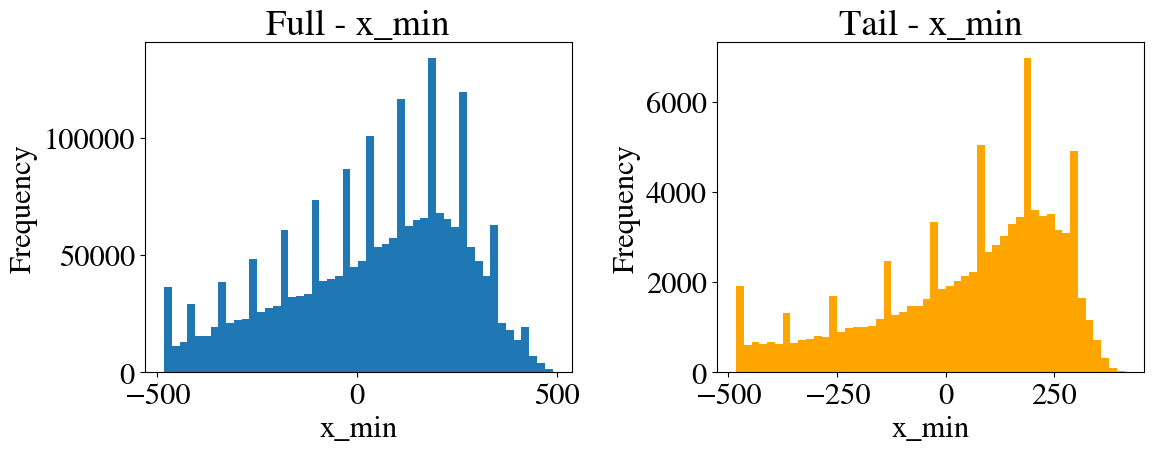

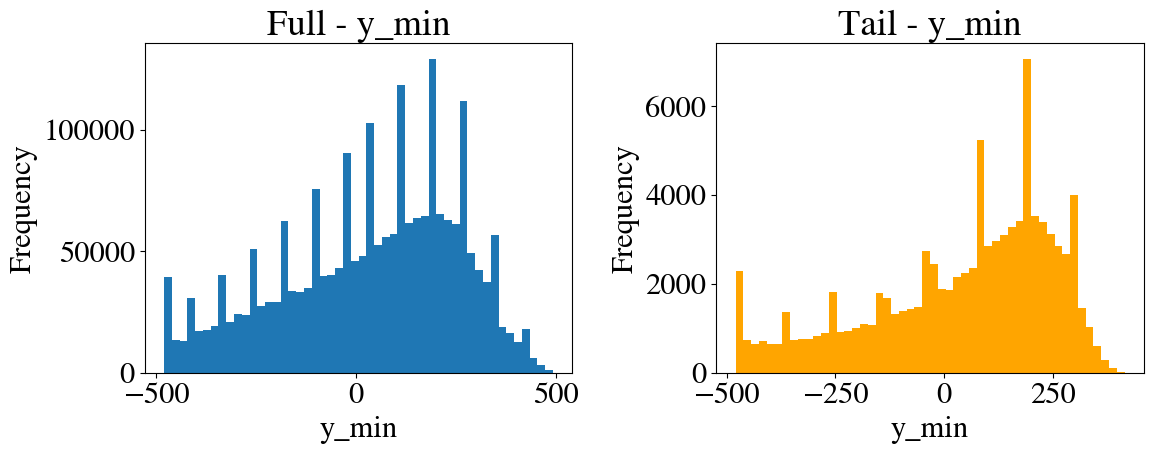

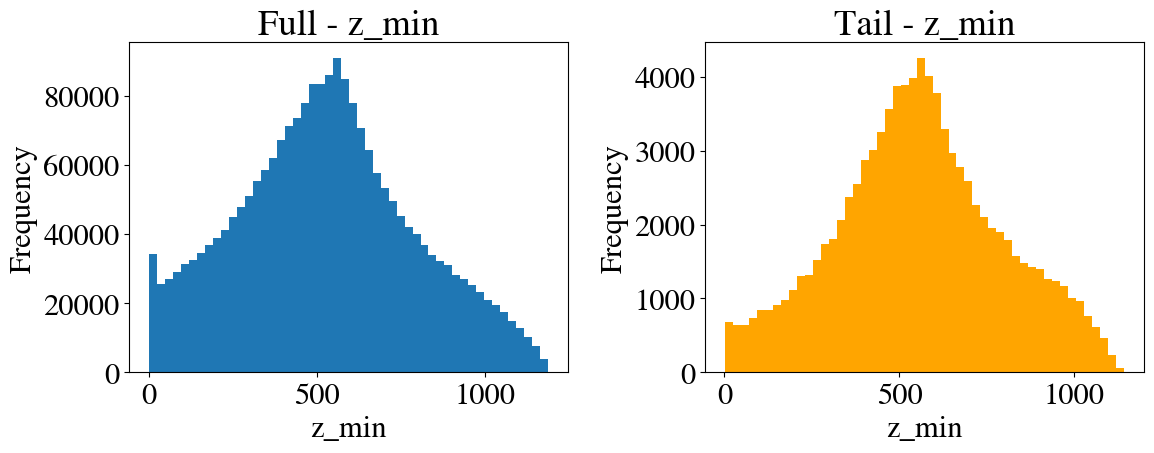

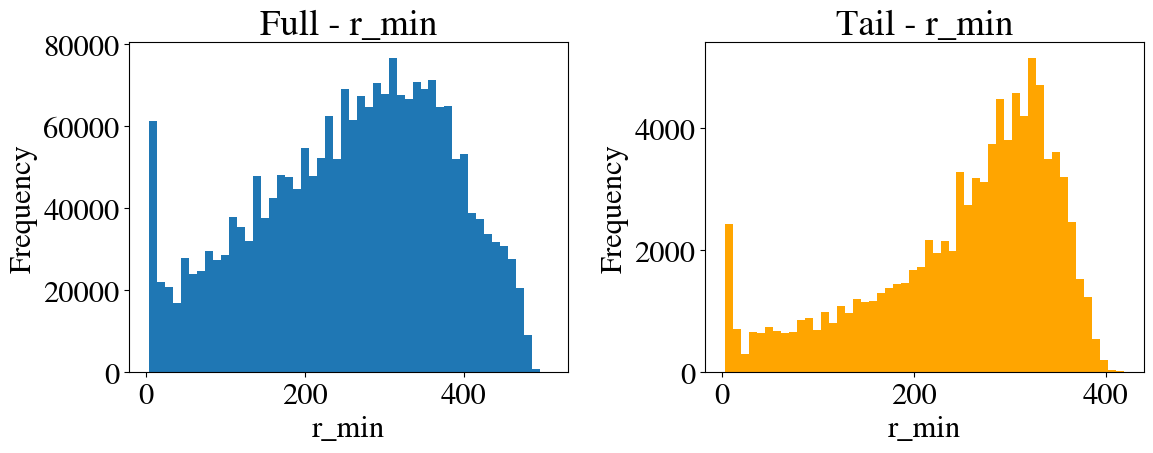

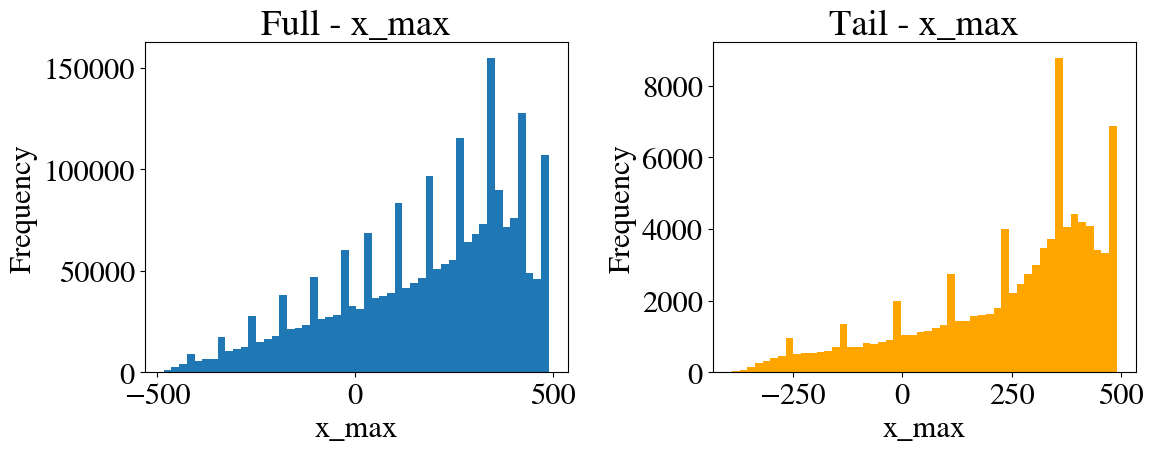

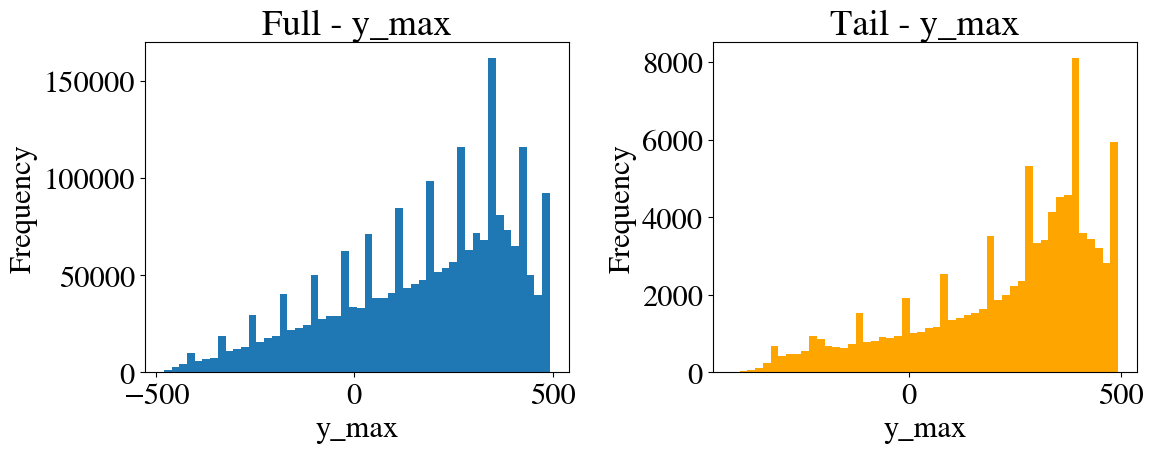

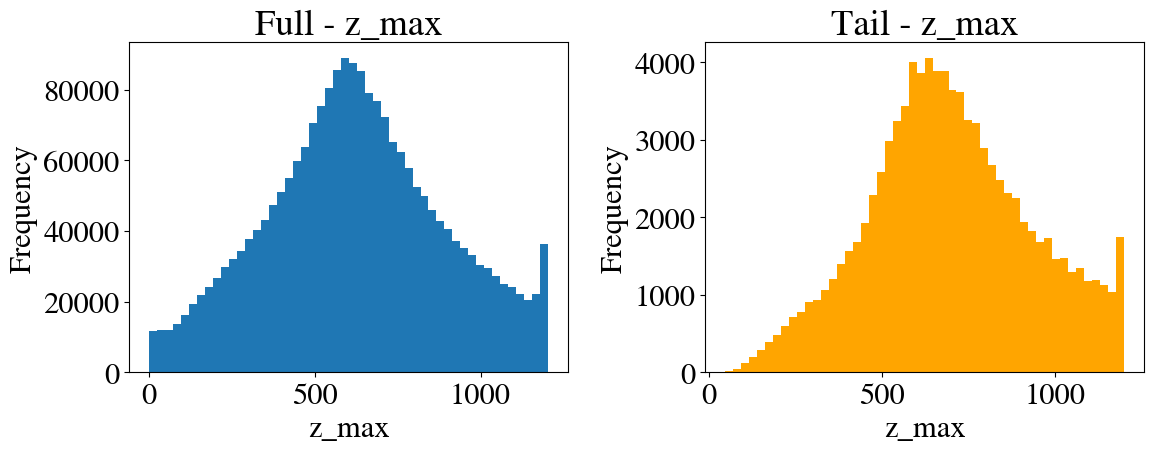

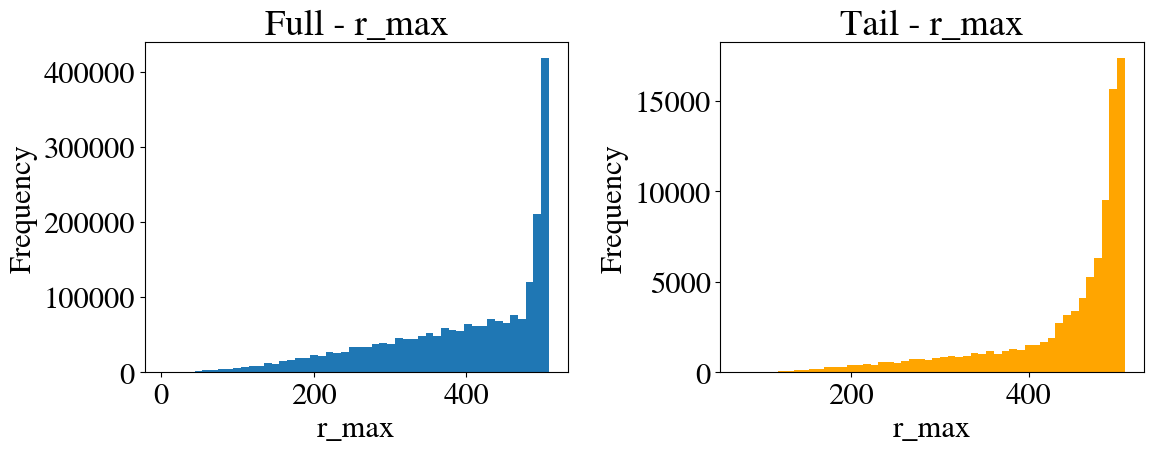

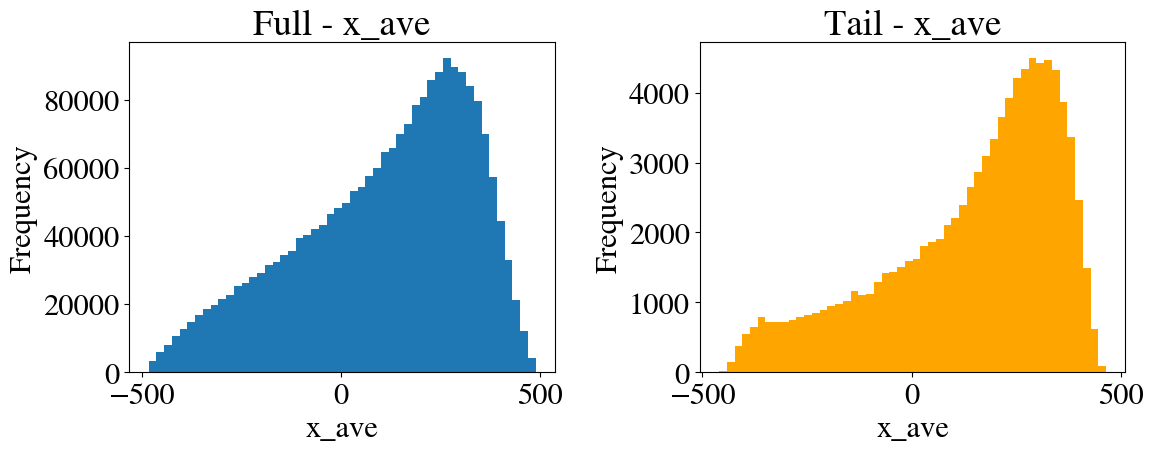

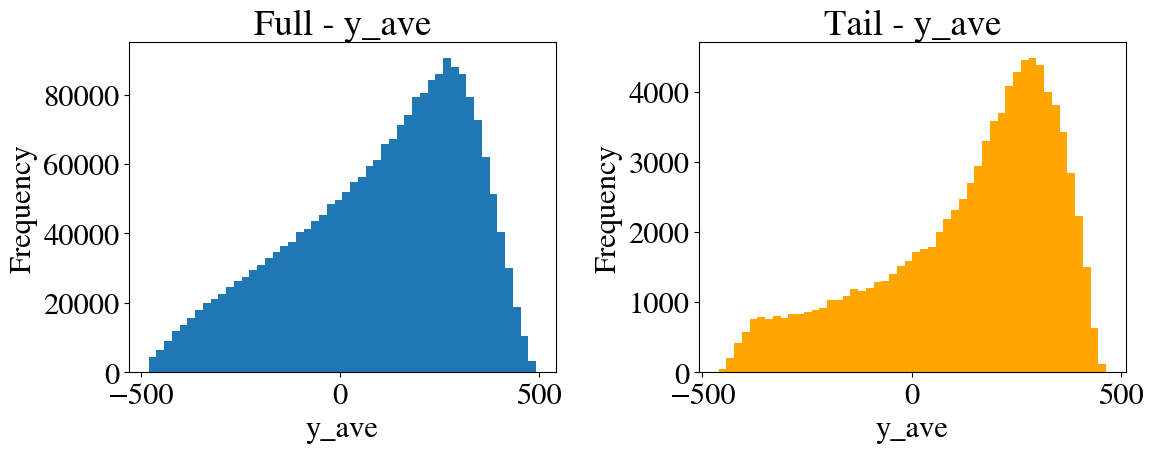

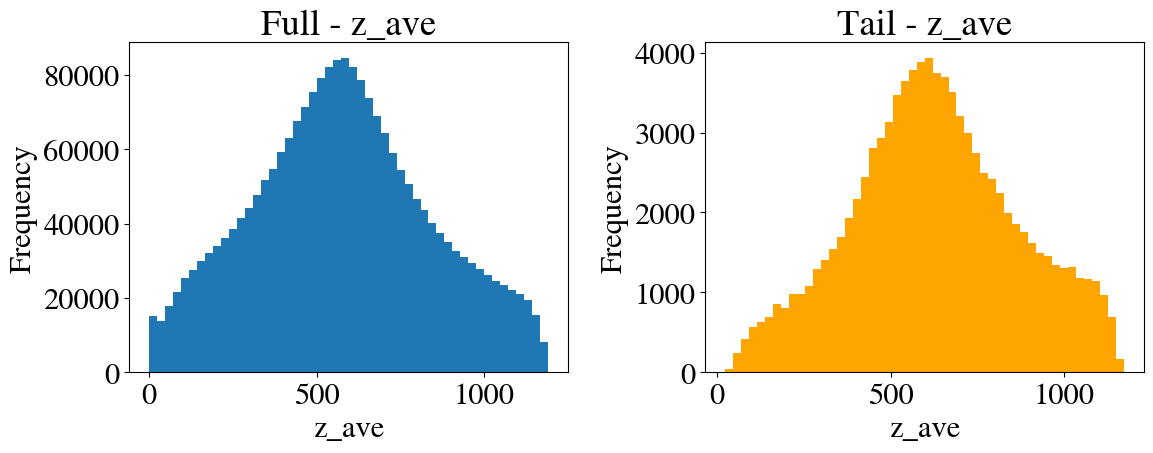

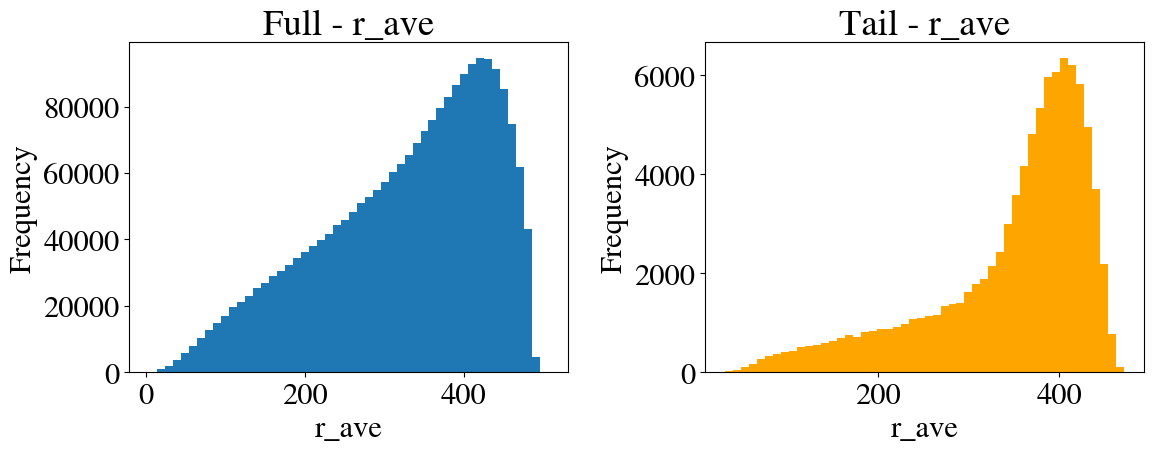

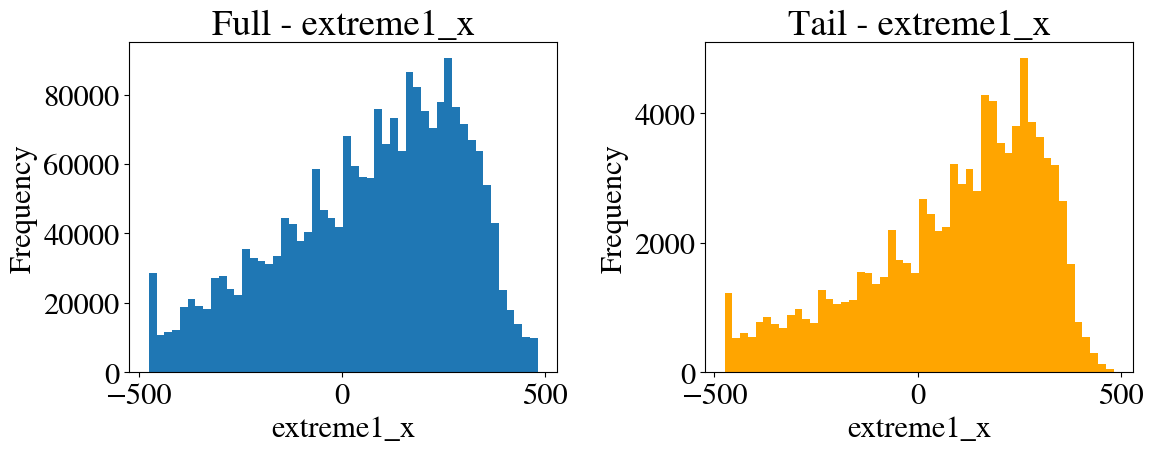

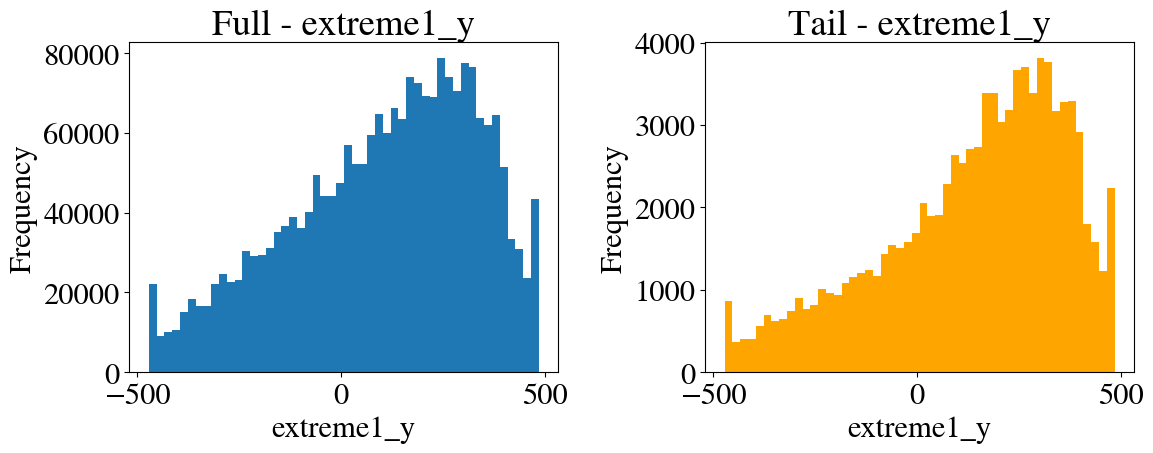

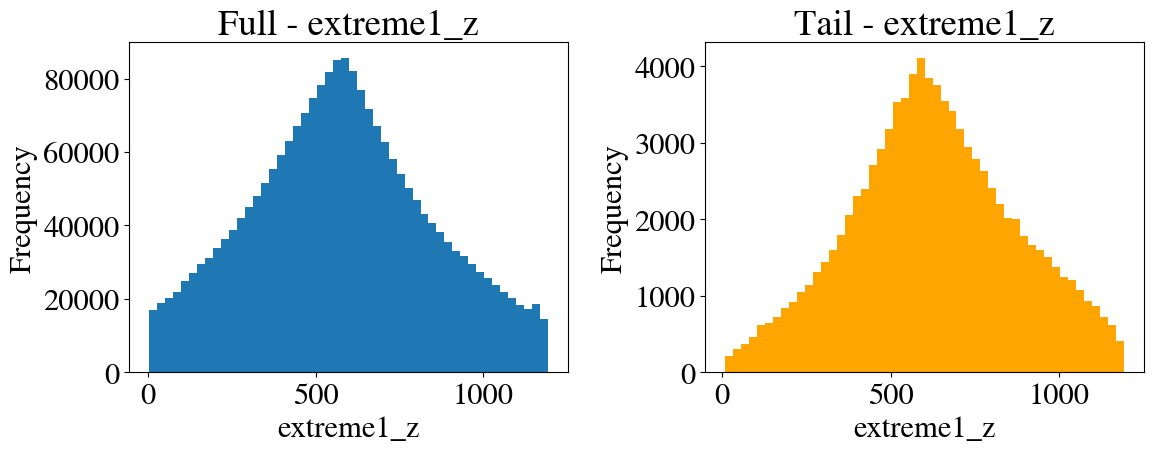

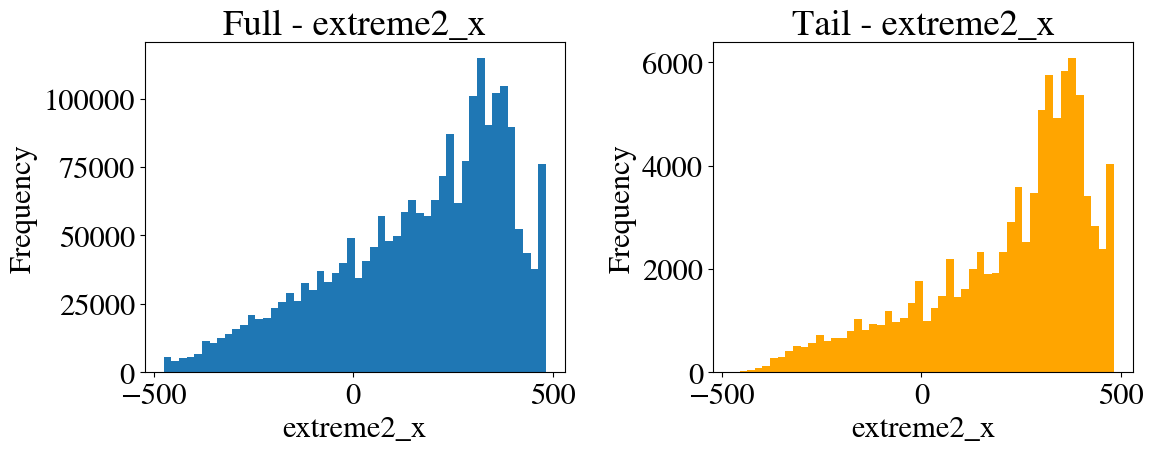

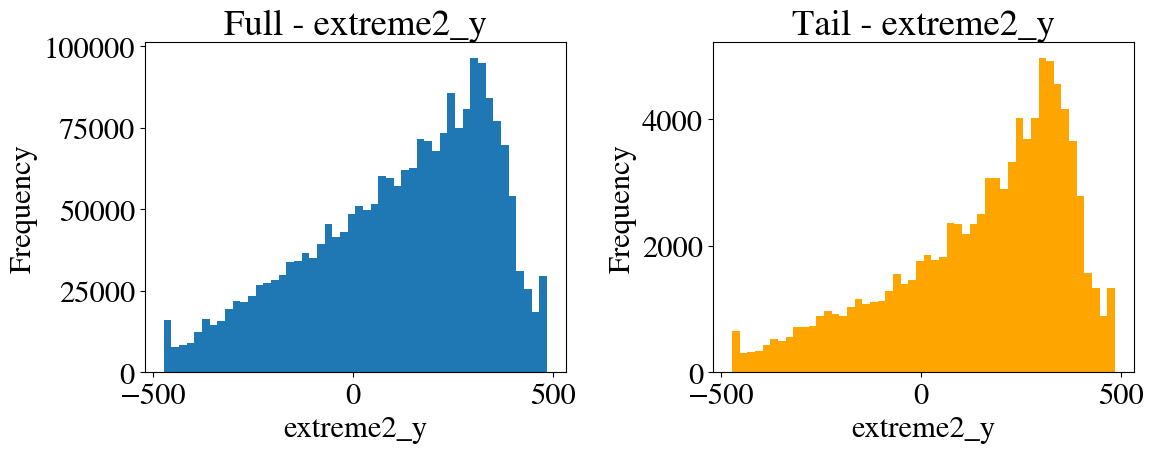

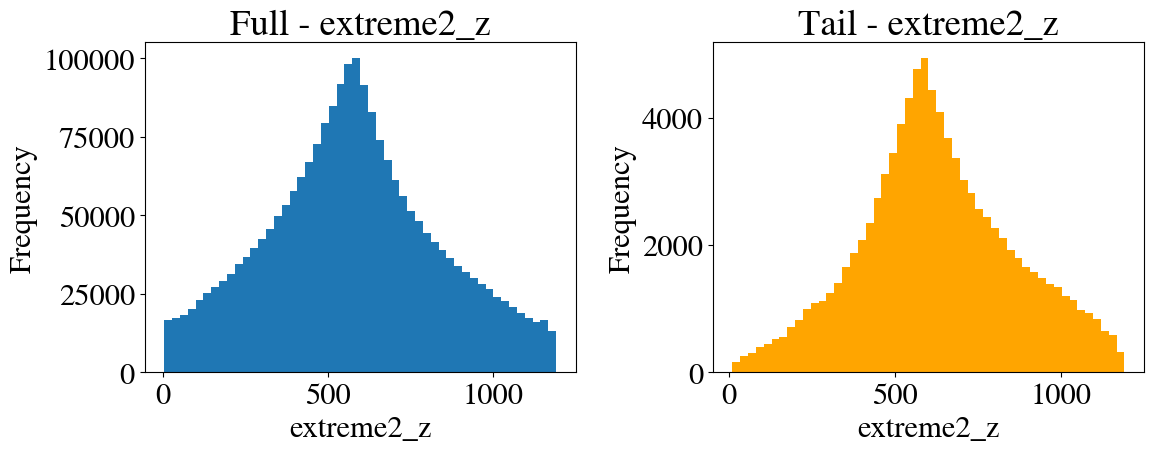

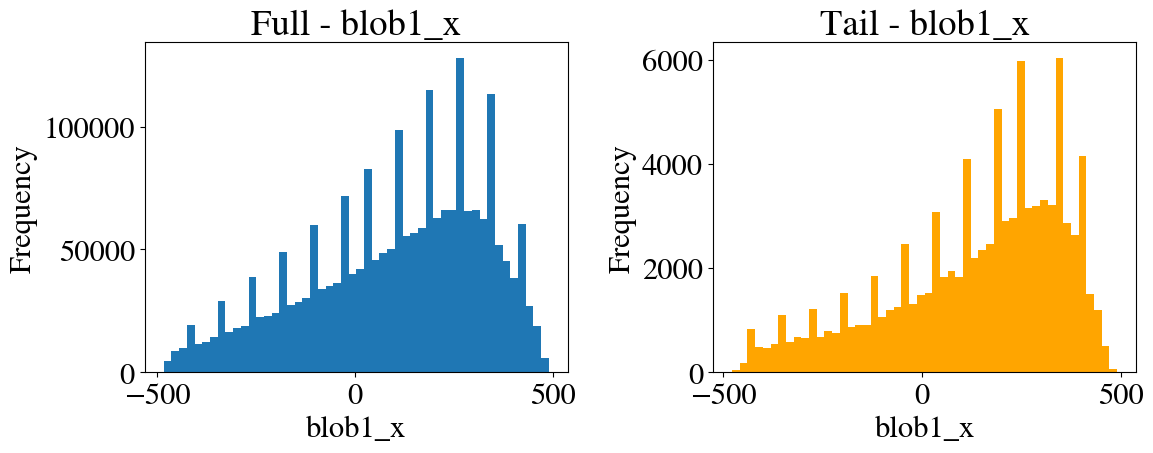

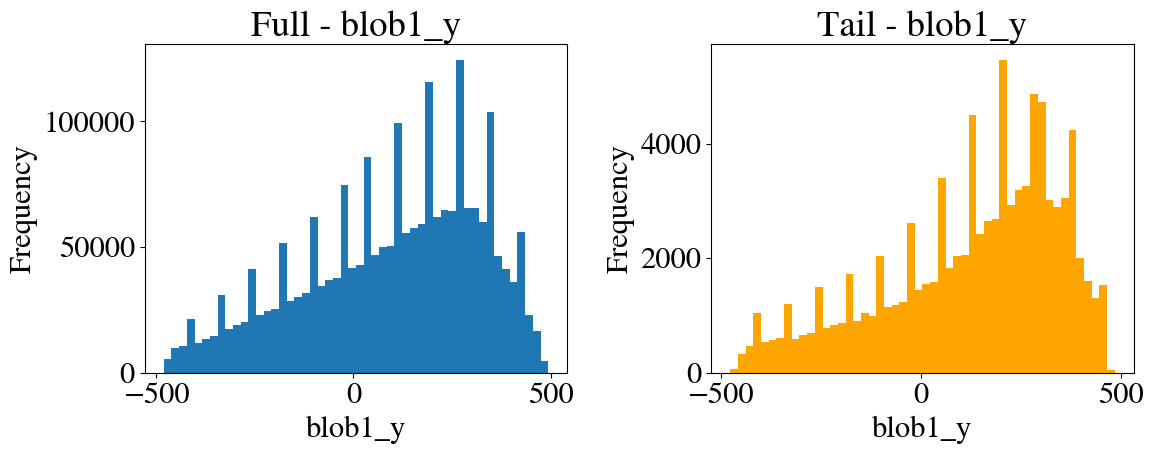

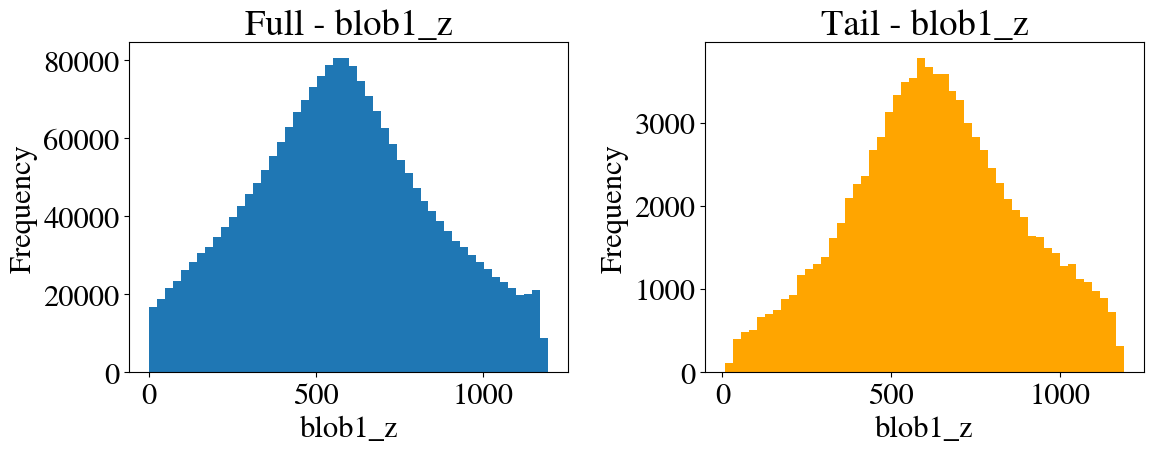

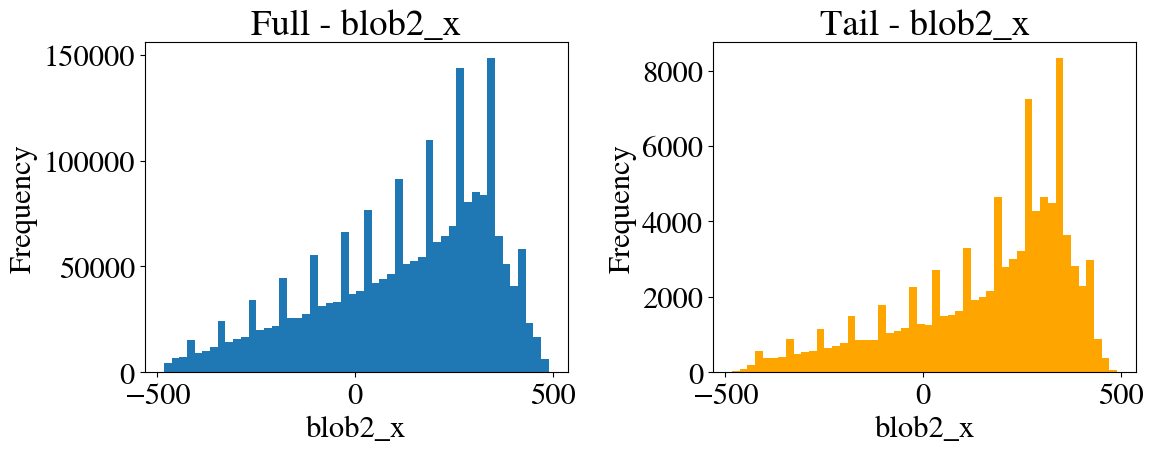

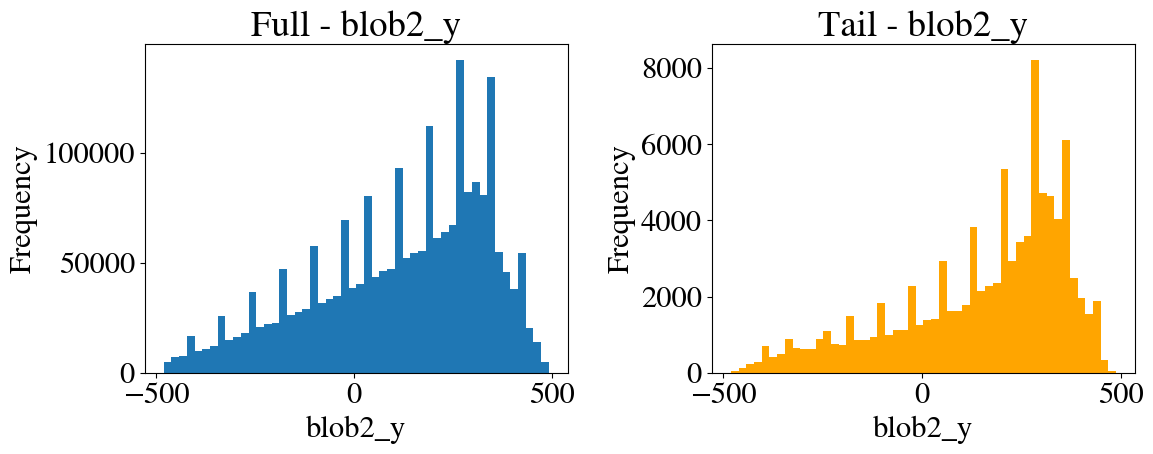

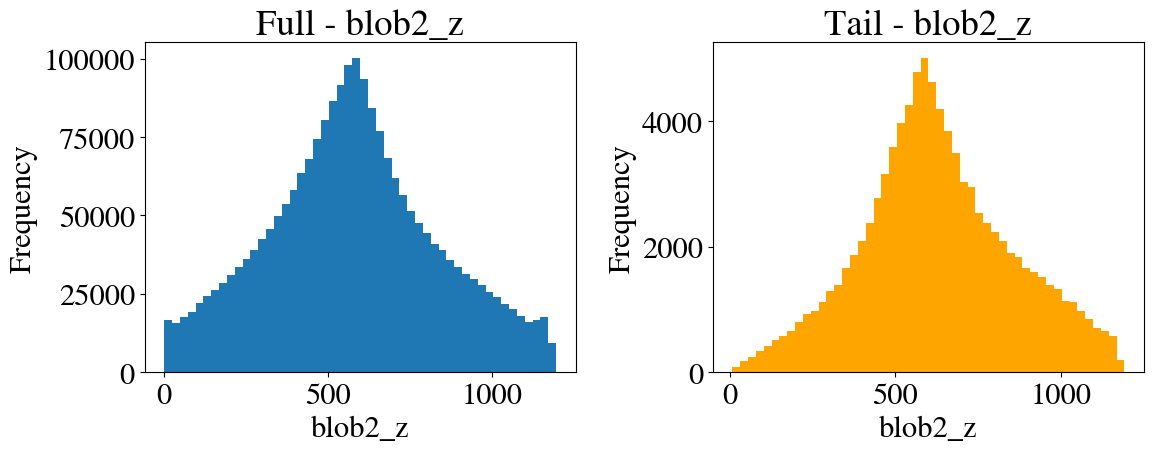

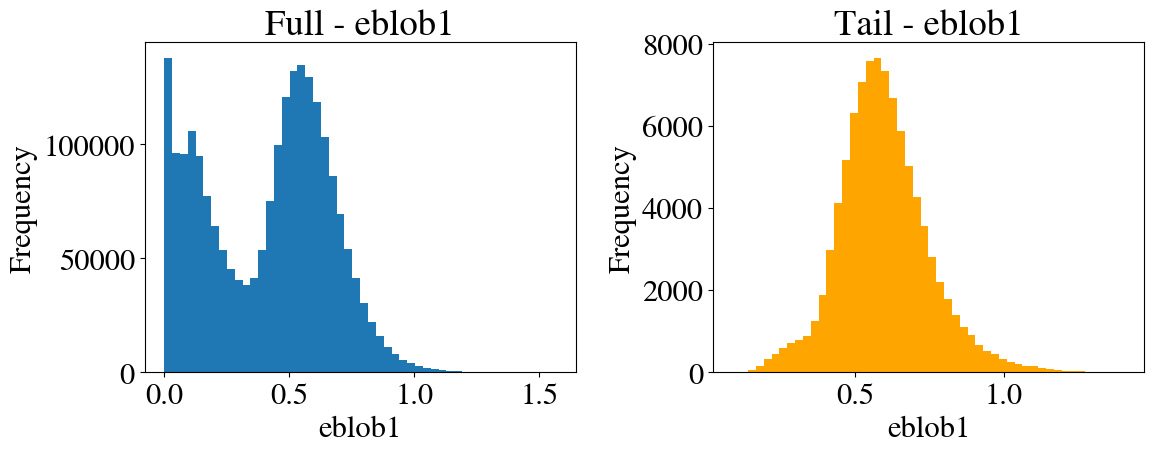

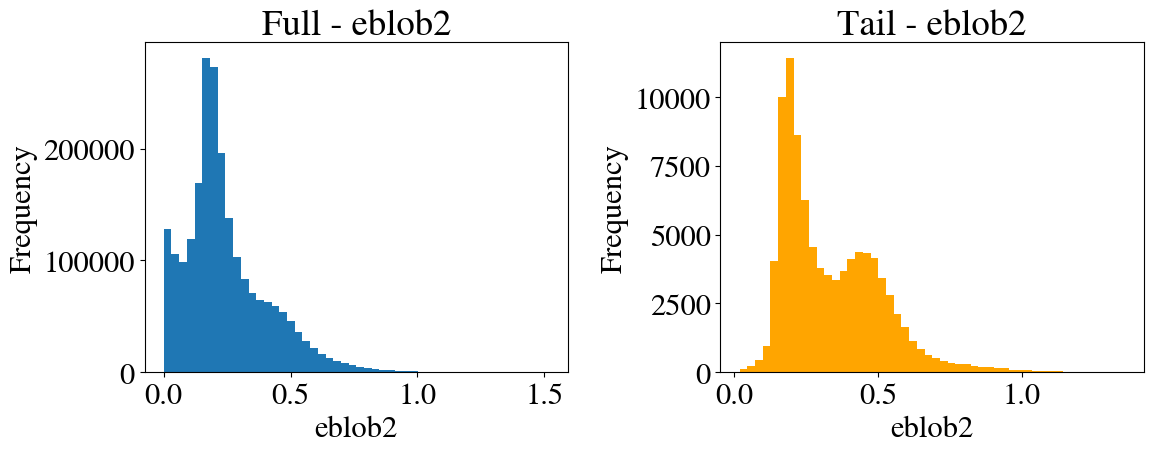

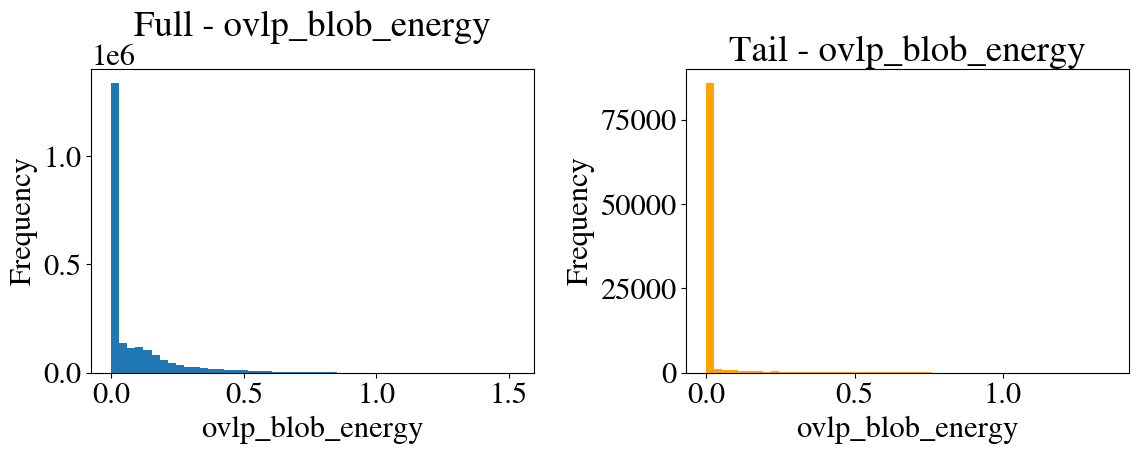

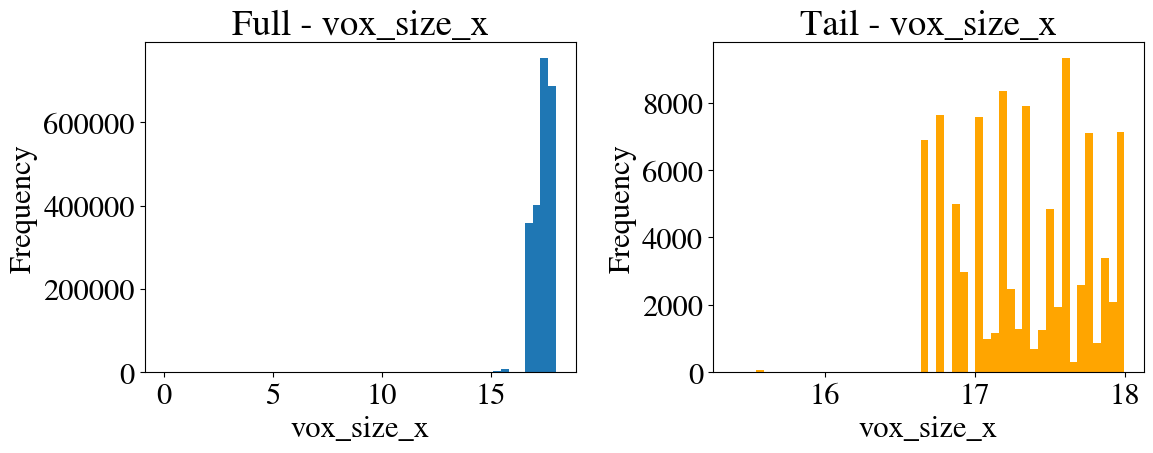

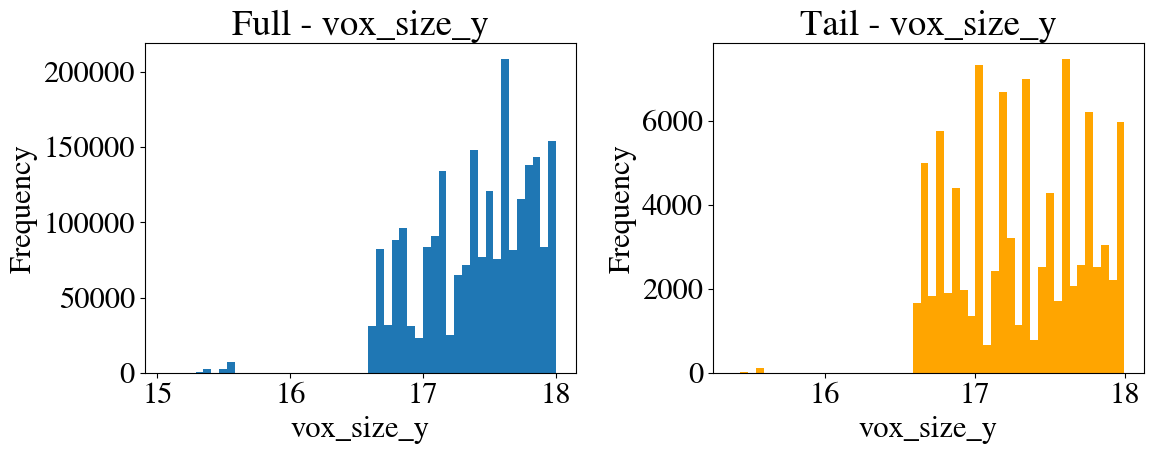

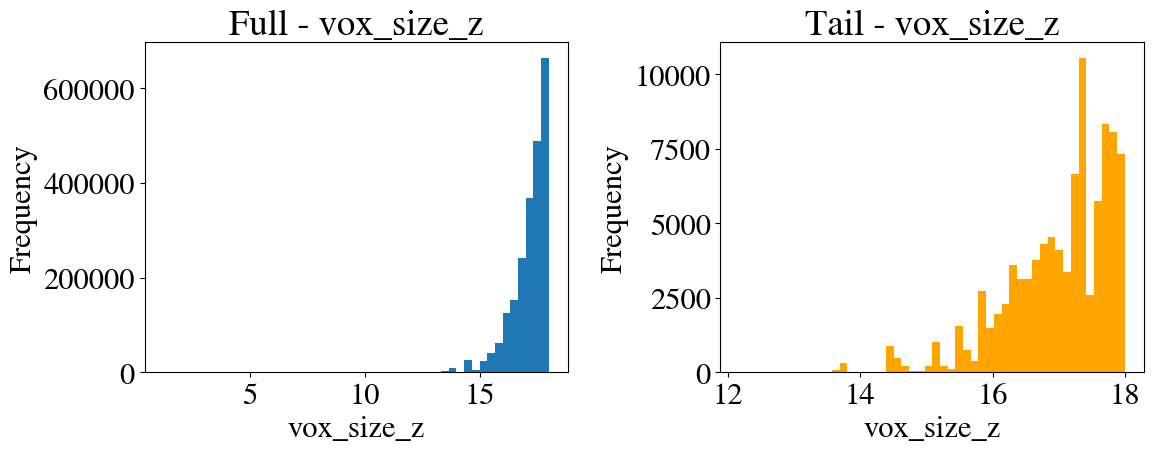

In [51]:
for traits in tail_hdst.columns.values:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].hist(hdst[traits].values, bins=50, range=(hdst[traits].min(), hdst[traits].max()))
    axs[0].set_title(f'Full - {traits}')
    
    axs[1].hist(tail_hdst[traits].values, bins=50, range=(tail_hdst[traits].min(), tail_hdst[traits].max()), color = 'orange')
    axs[1].set_title(f'Tail - {traits}')
    
    for ax in axs:
        ax.set_xlabel(traits)
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [63]:
# apply fiducial cuts
cut_hdst = func.fiducial_track_cut_2(hdst, lower_z = 20, upper_z = 1170, r_lim = 450)
cut_tail_hdst = cut_hdst[(cut_hdst.energy > 1.62) & (cut_hdst.energy < 1.65)]

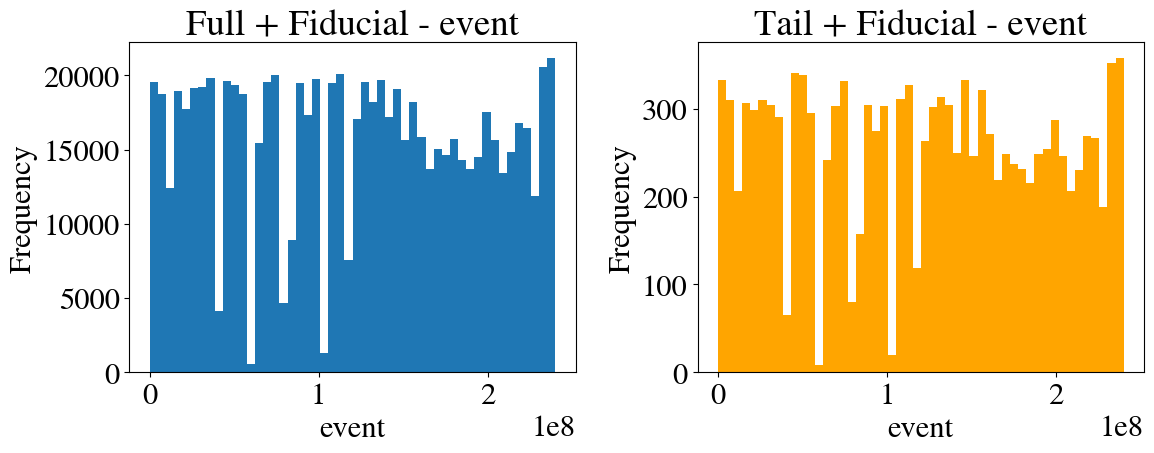

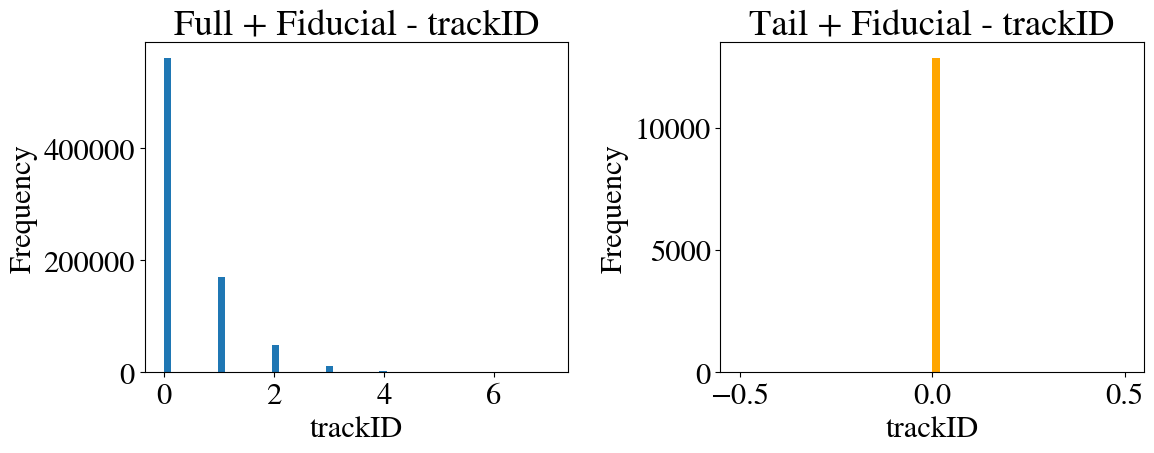

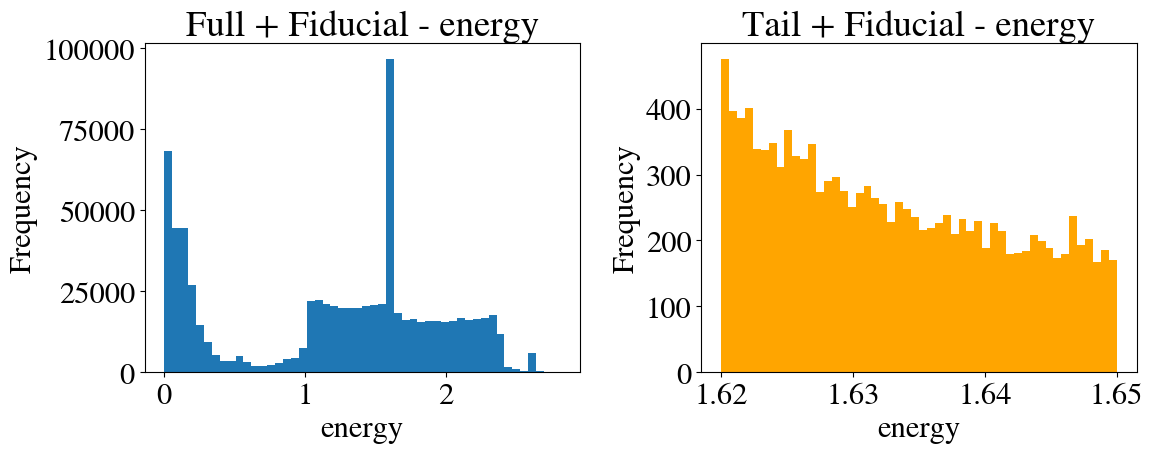

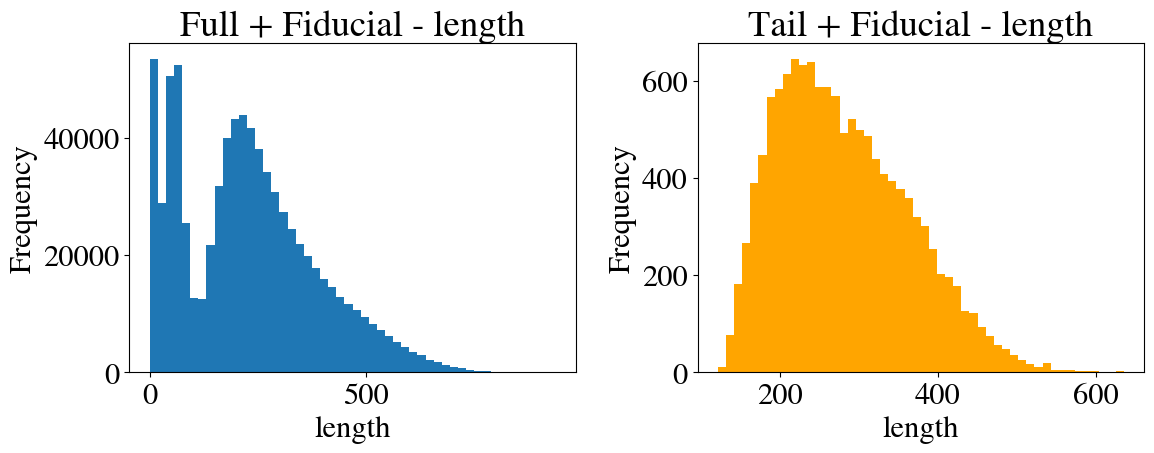

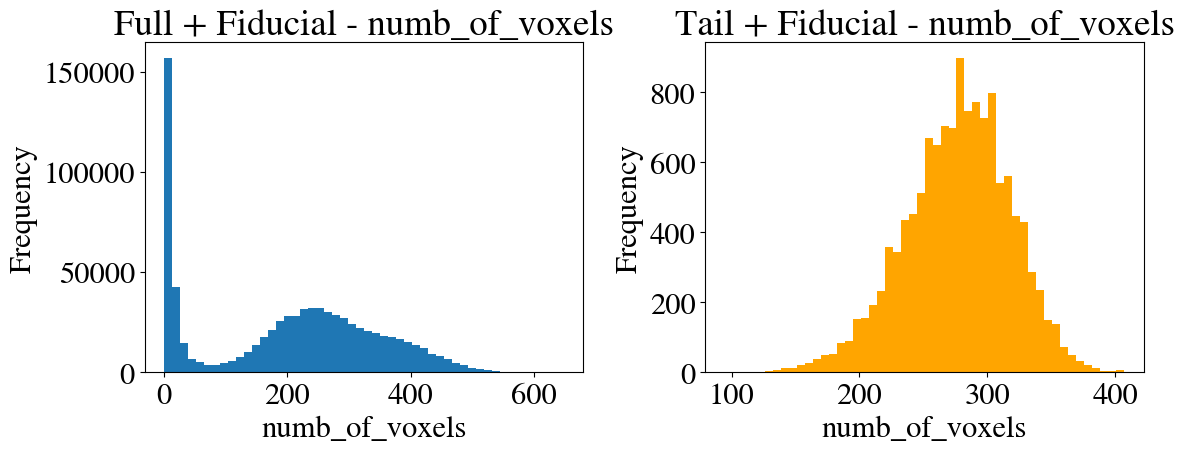

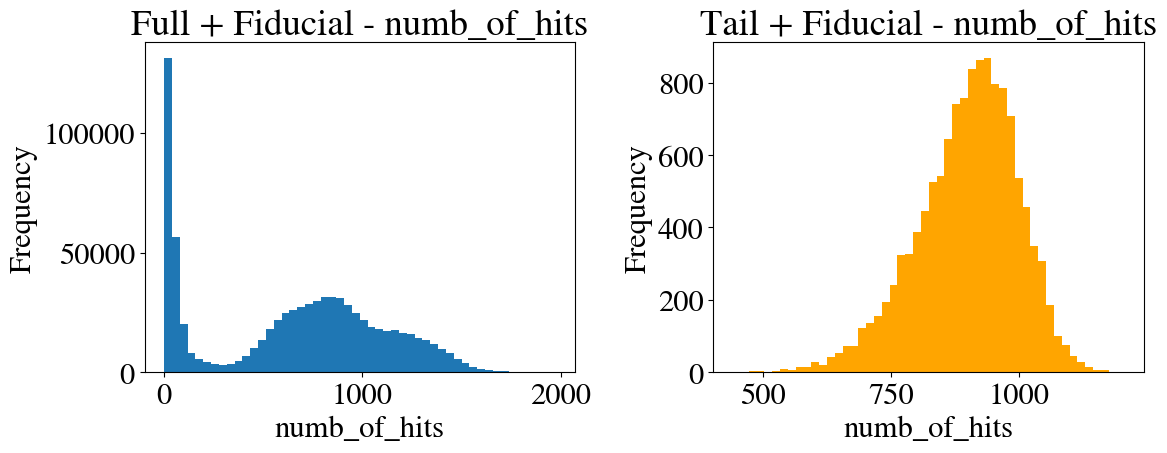

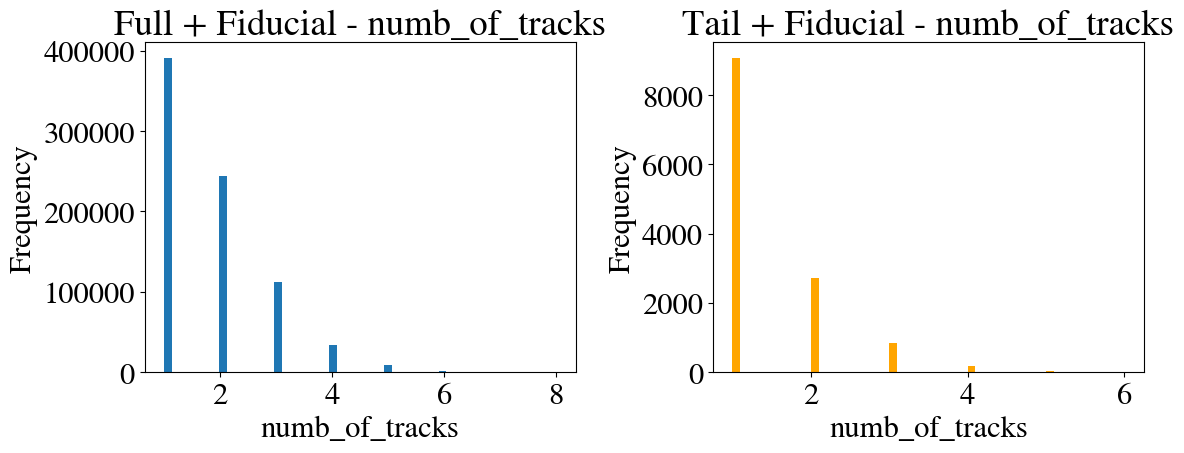

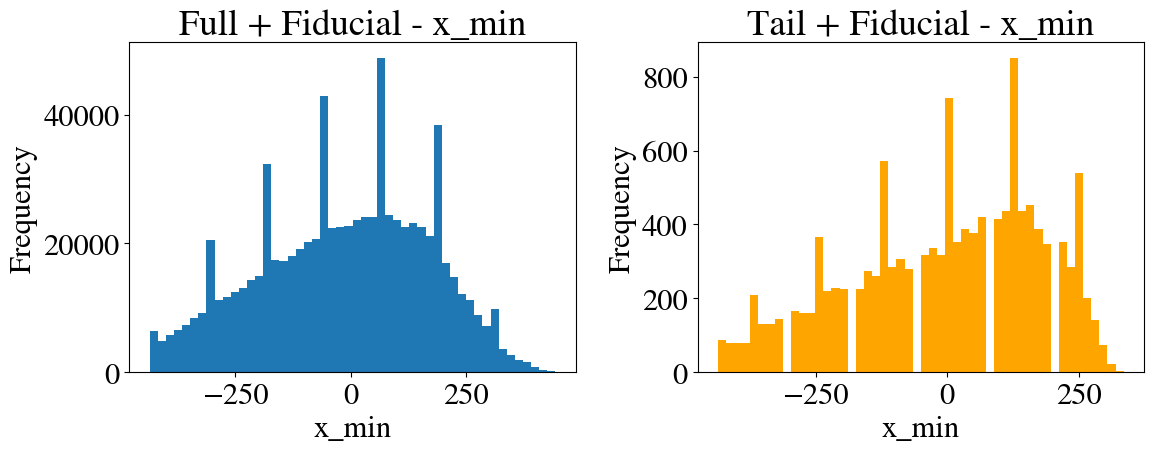

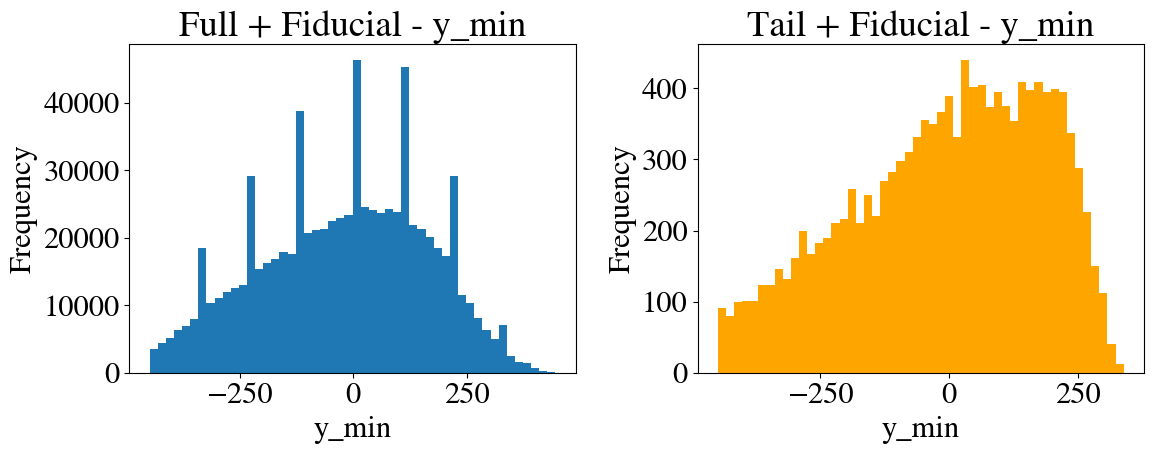

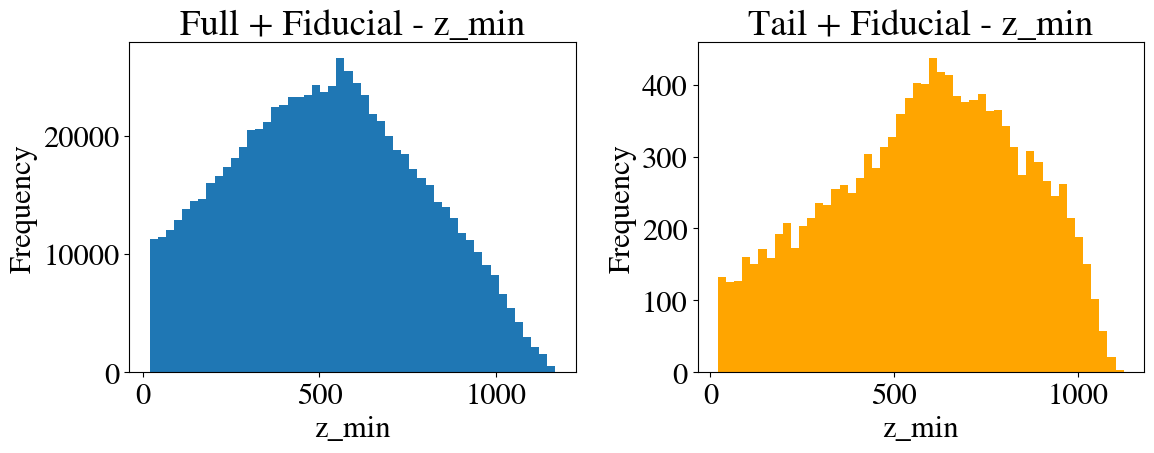

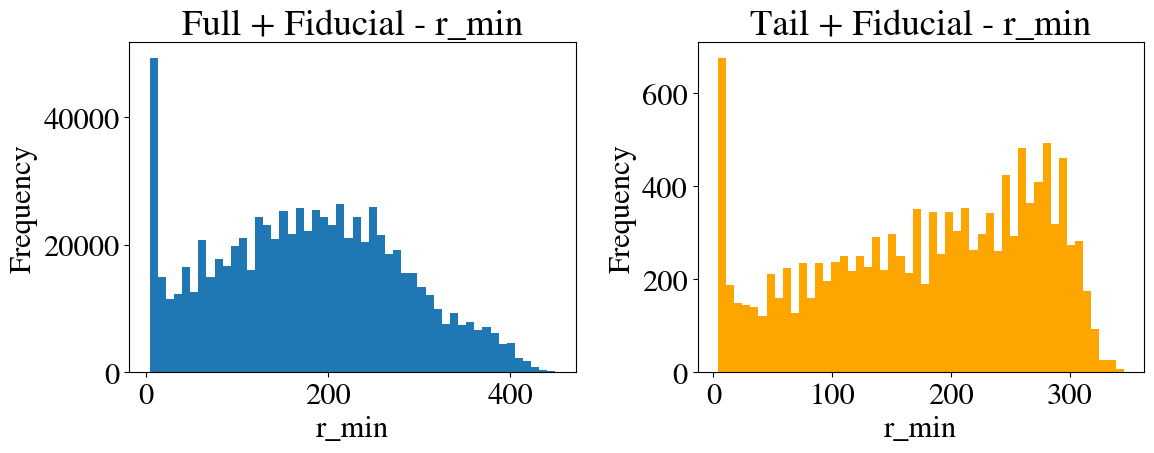

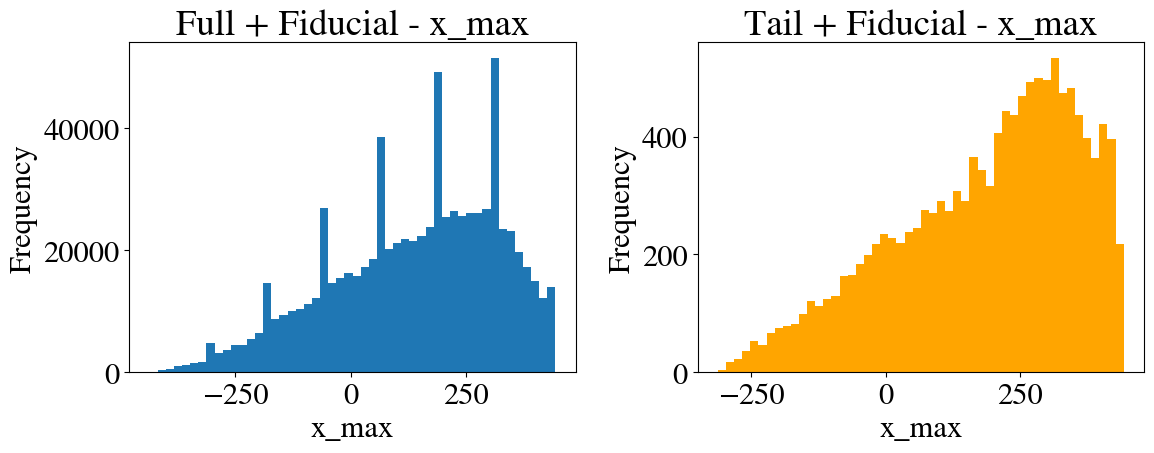

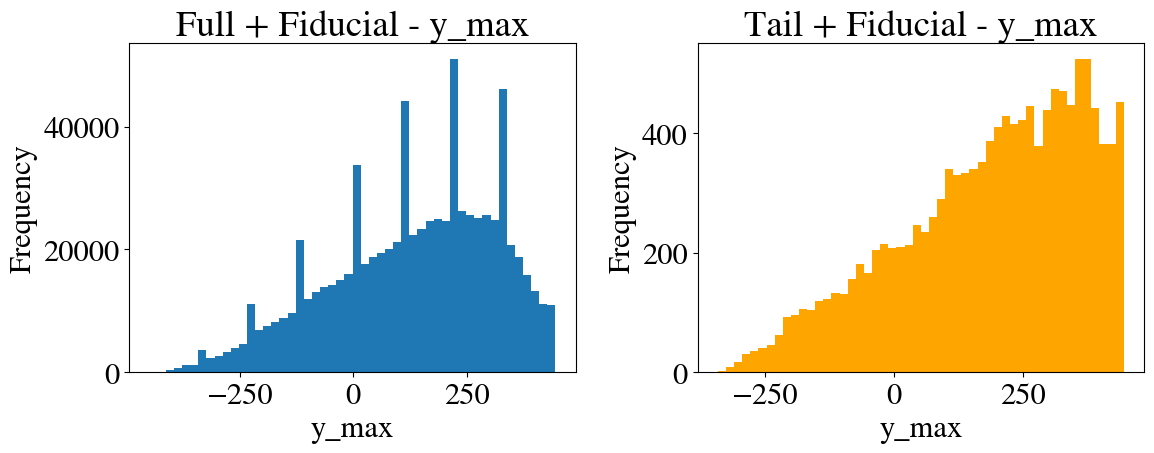

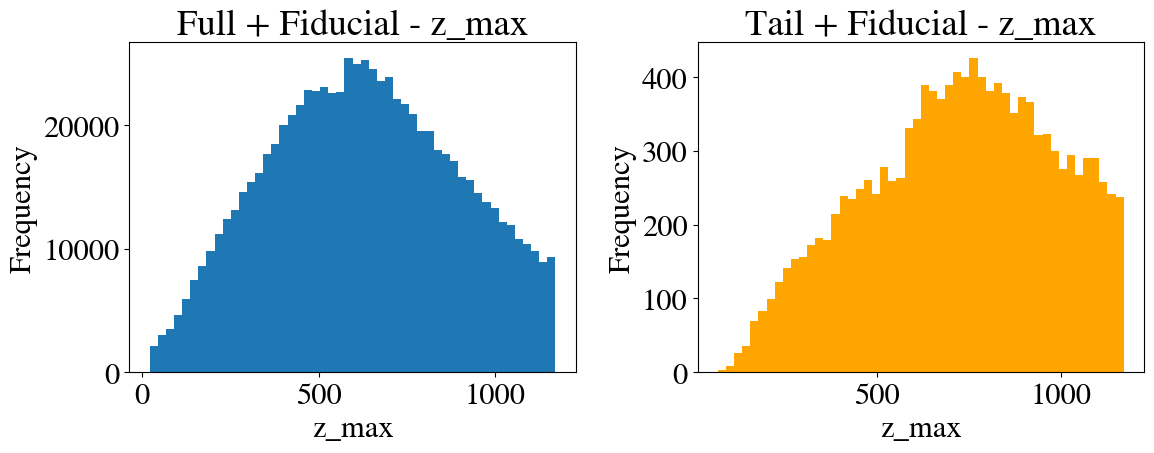

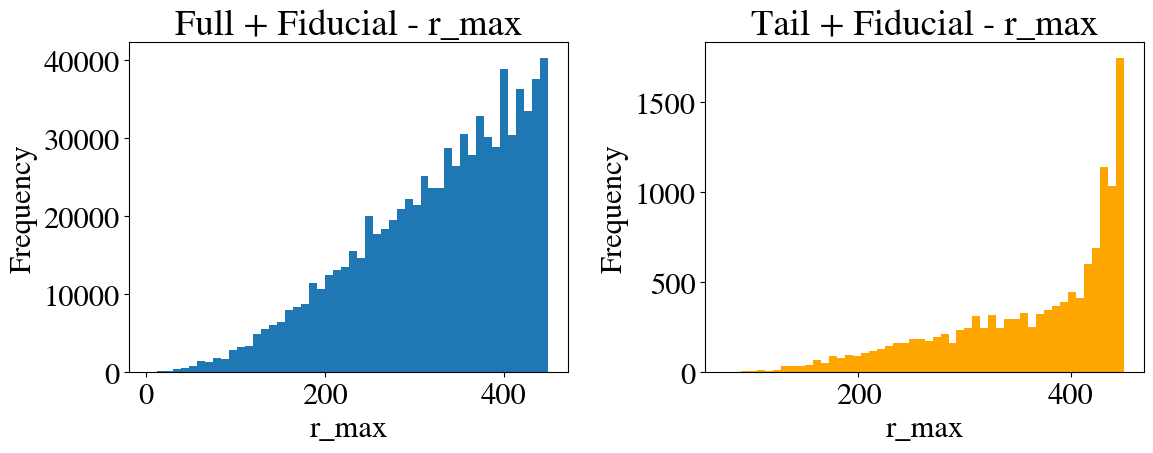

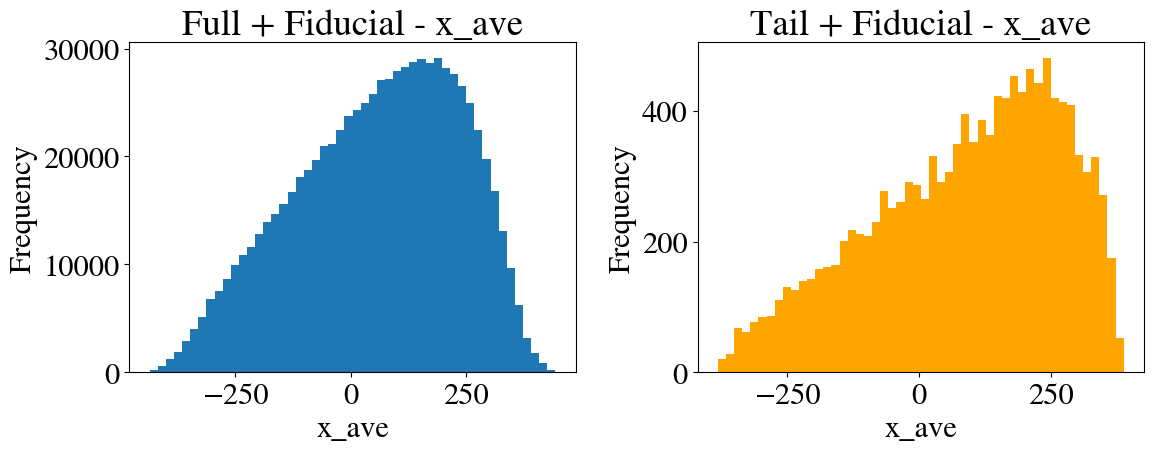

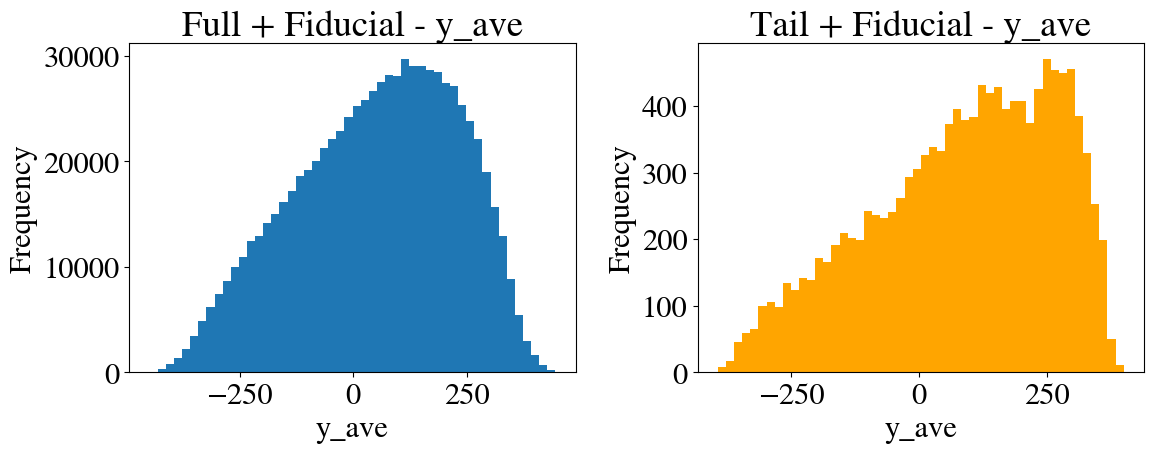

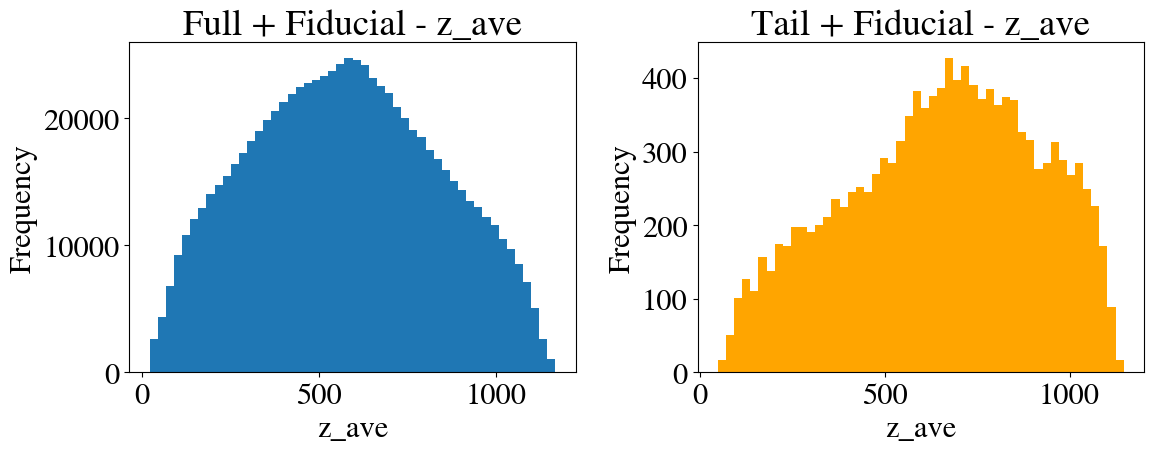

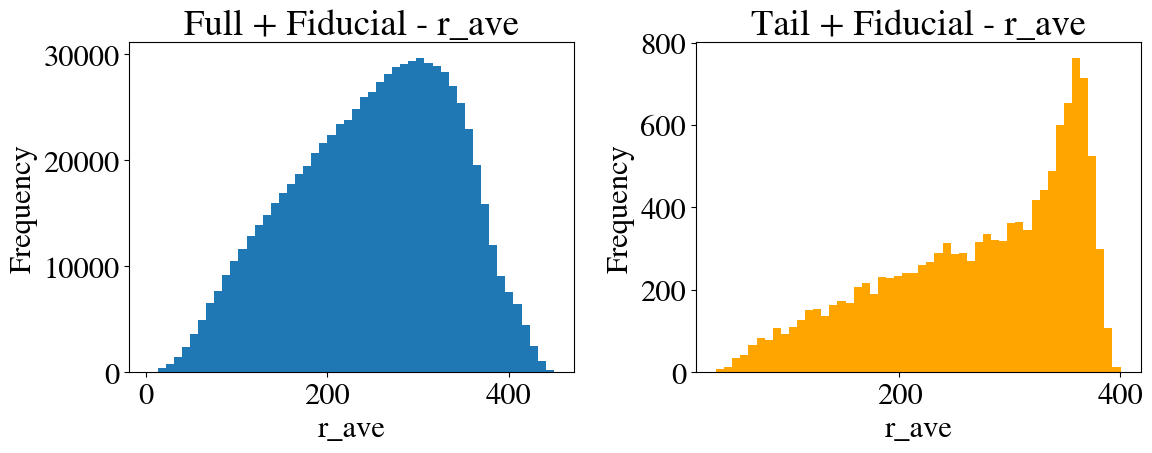

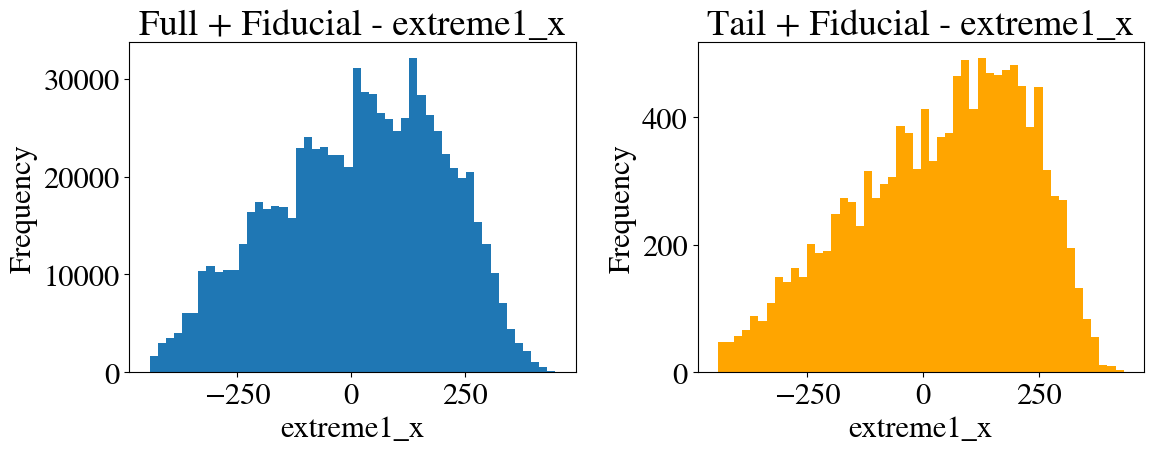

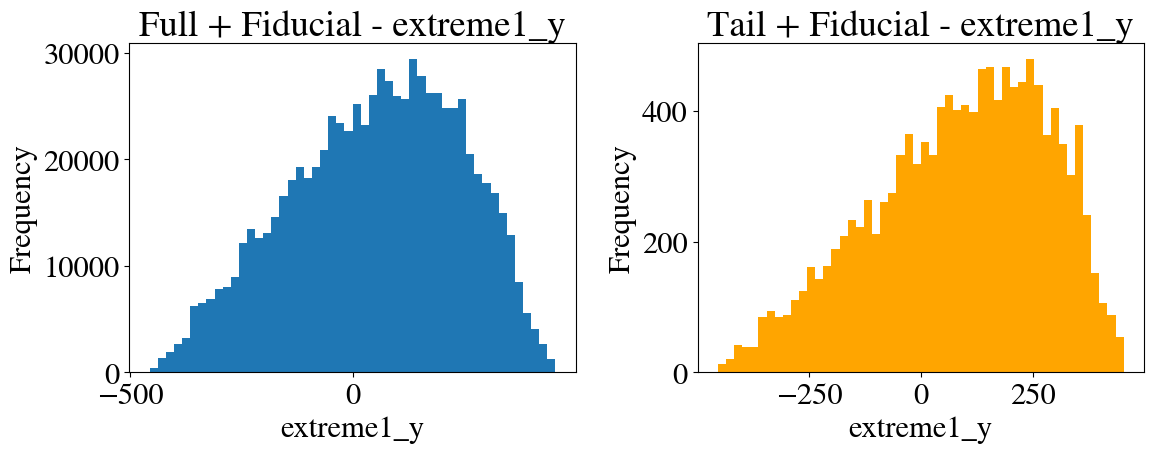

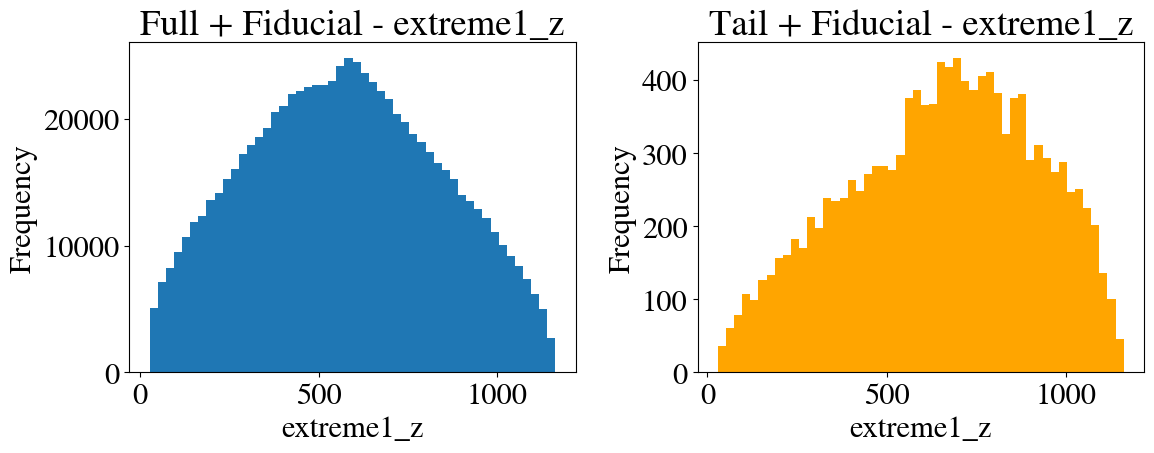

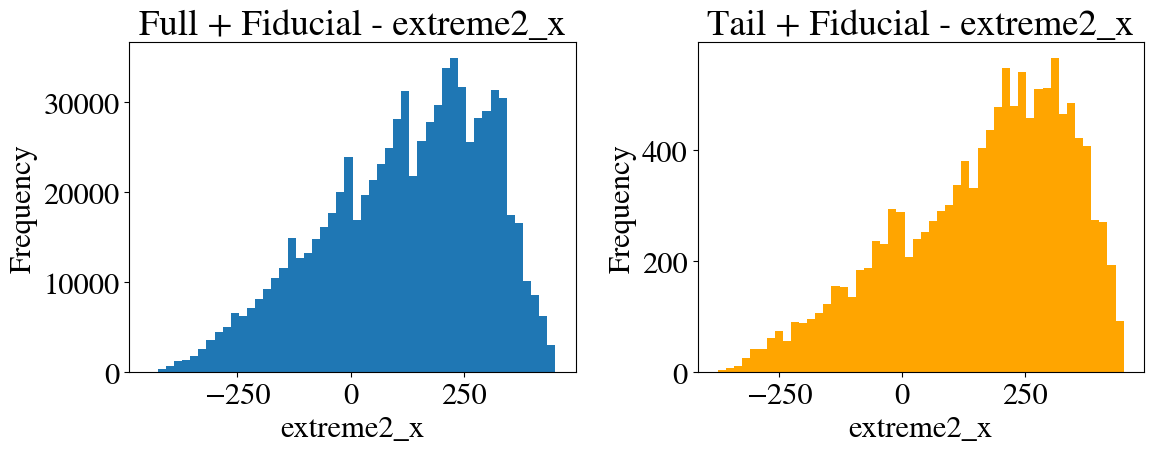

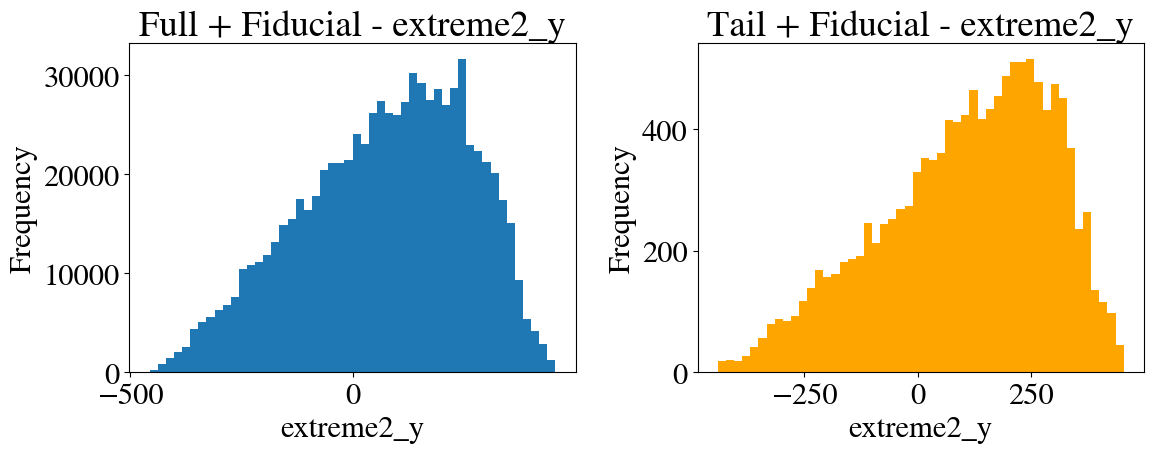

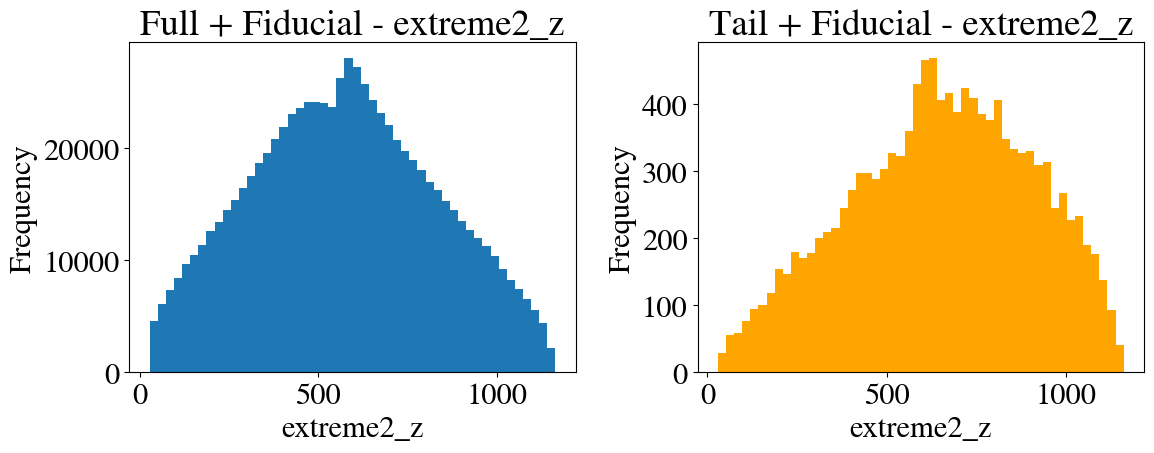

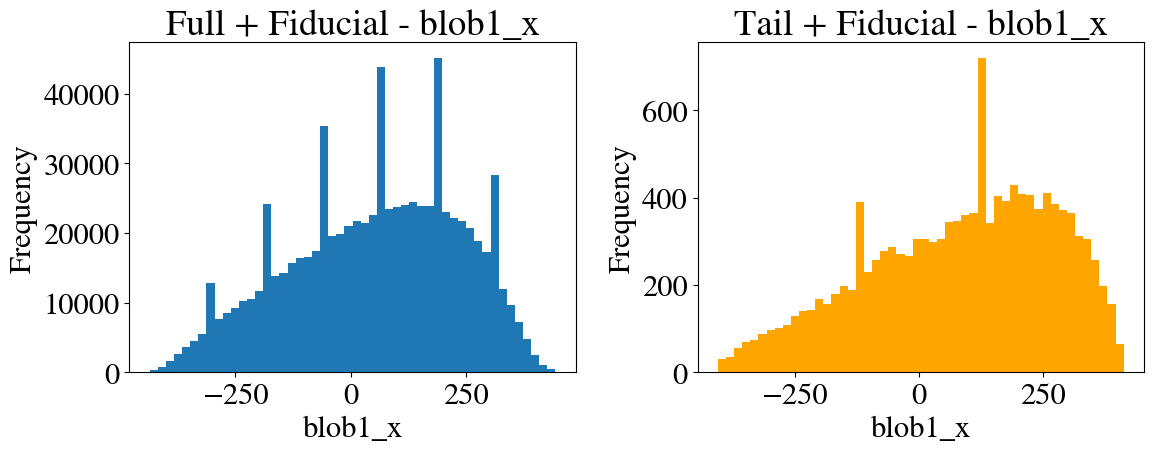

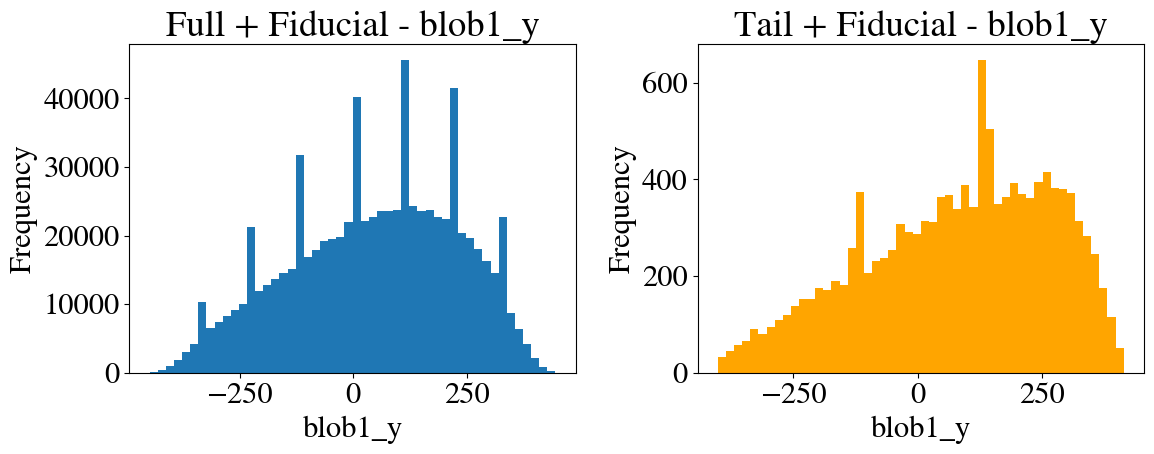

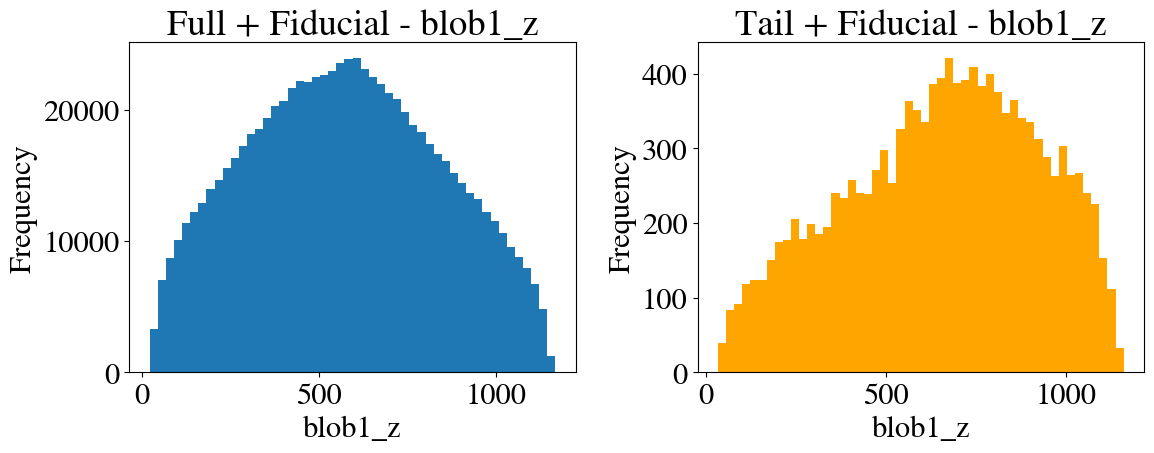

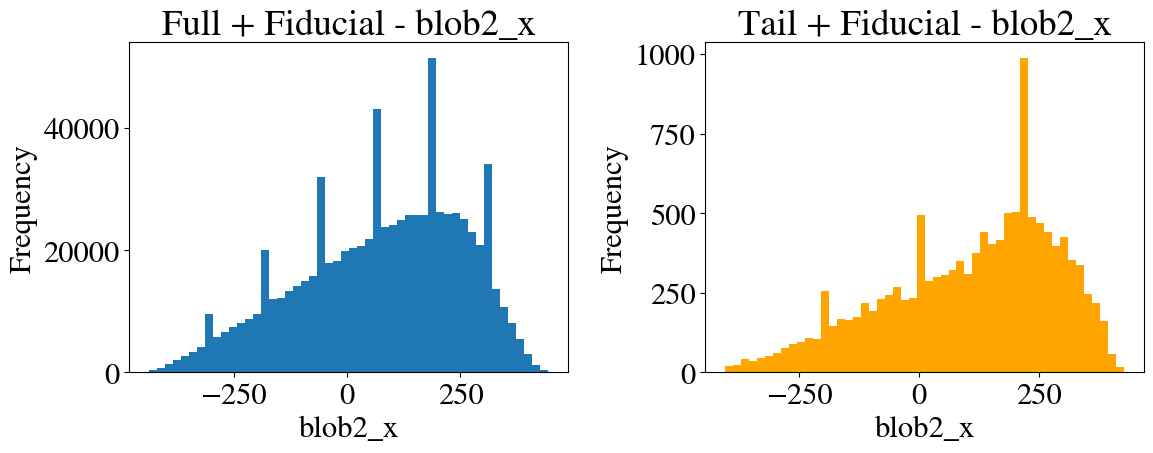

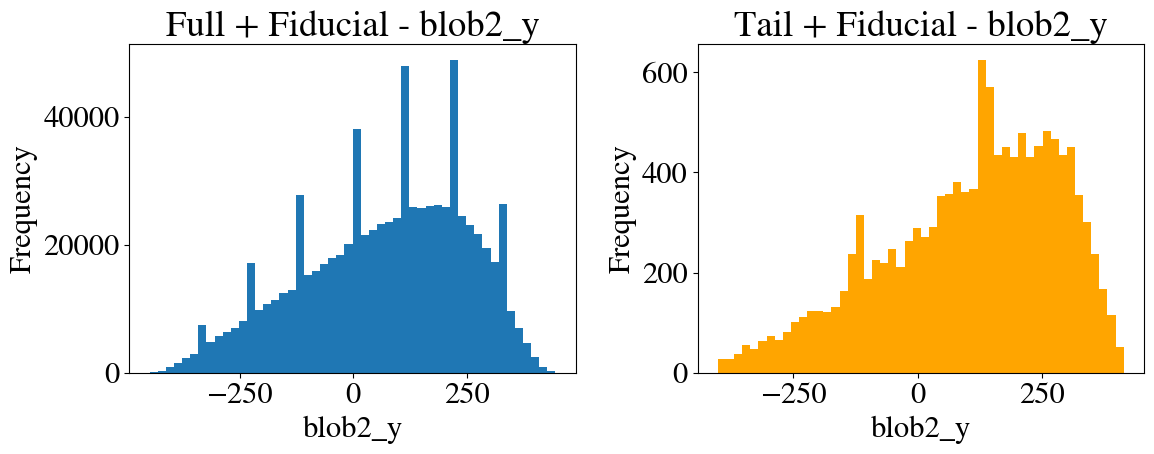

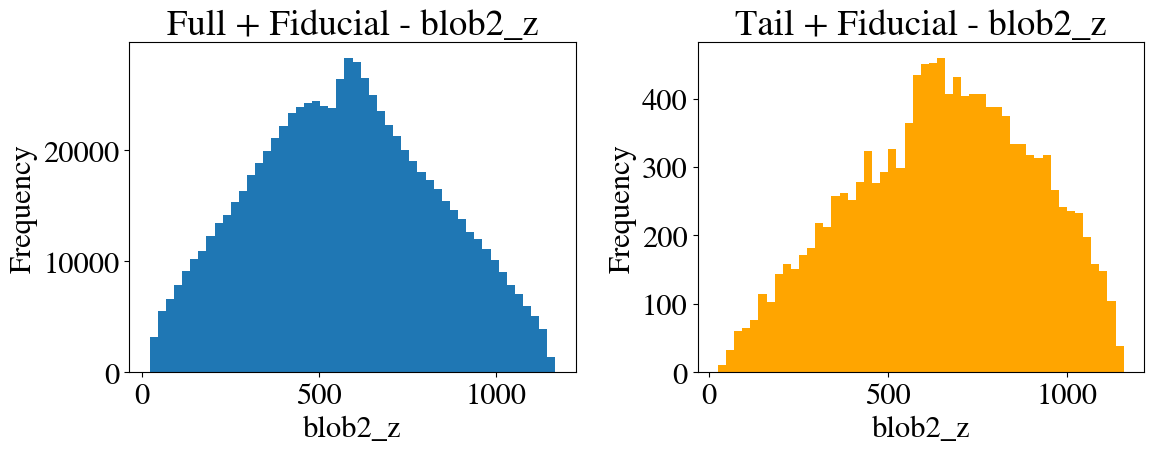

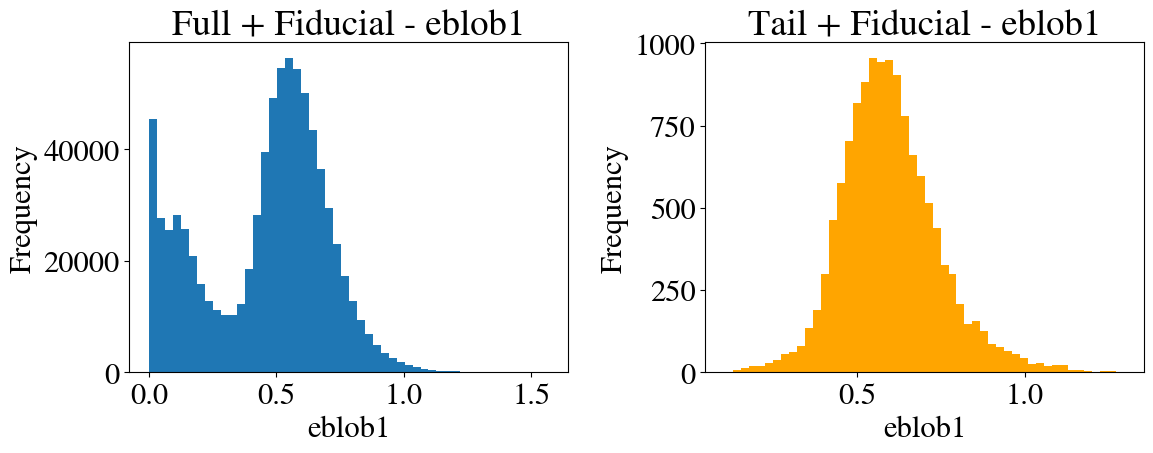

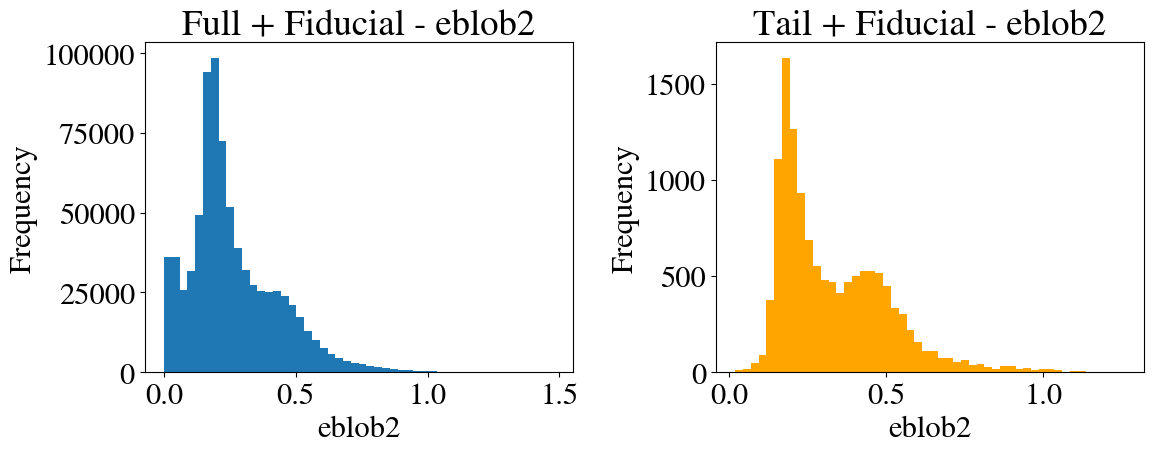

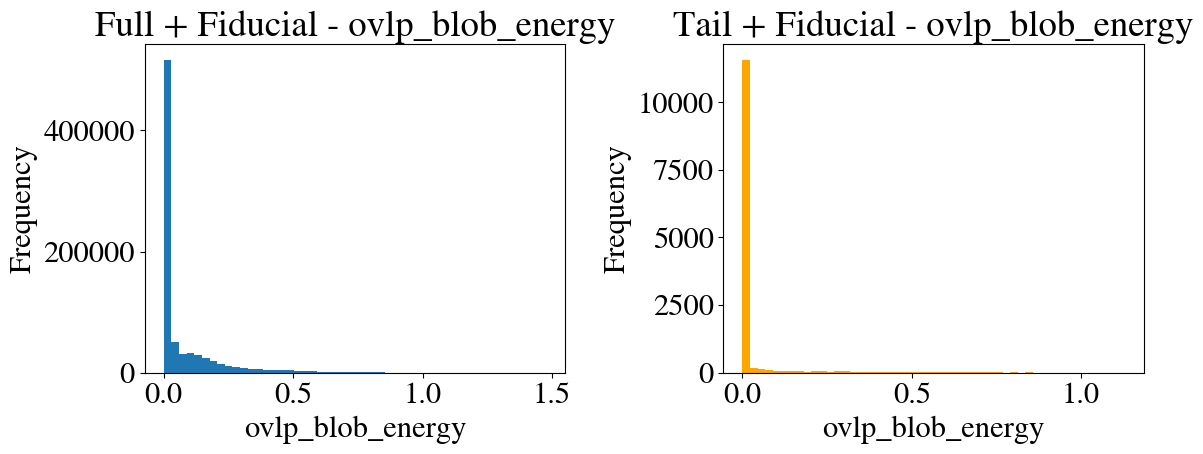

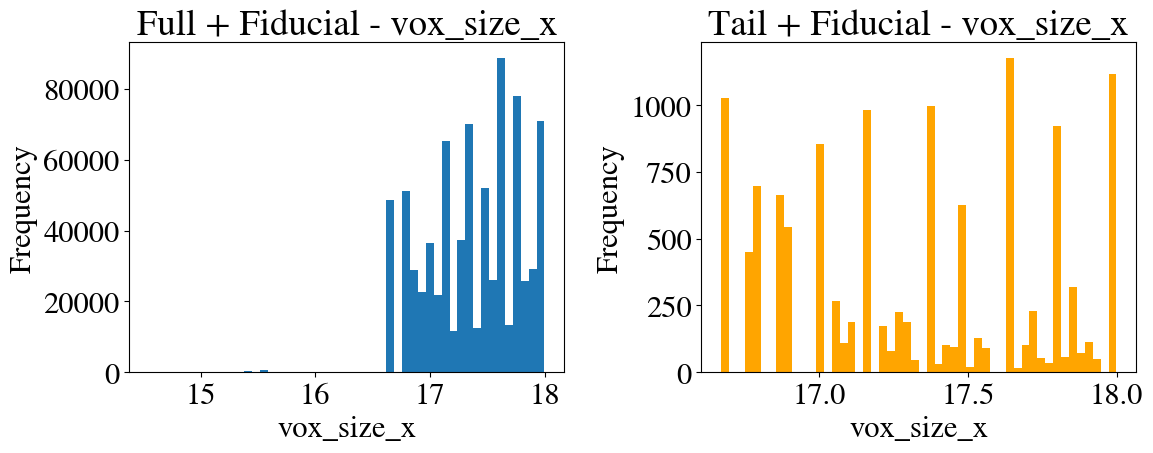

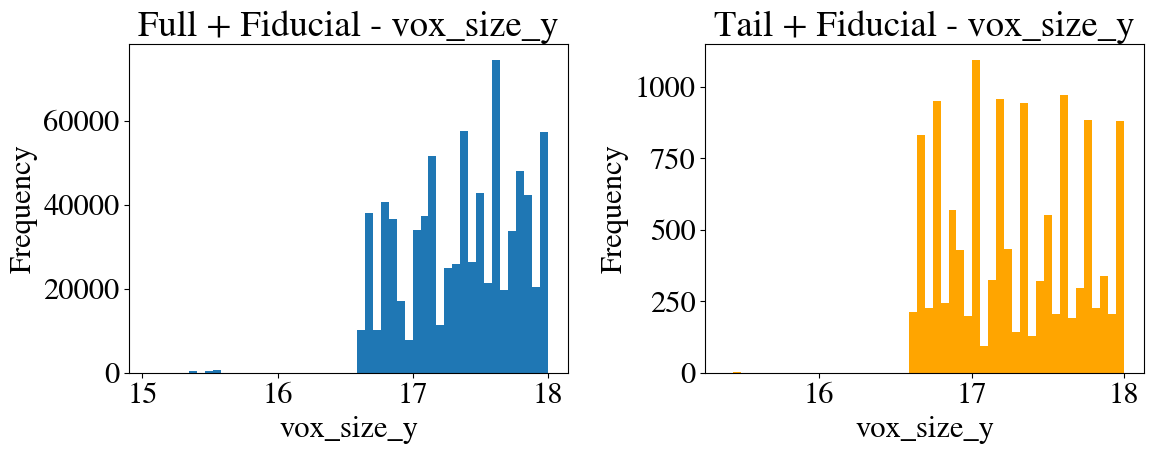

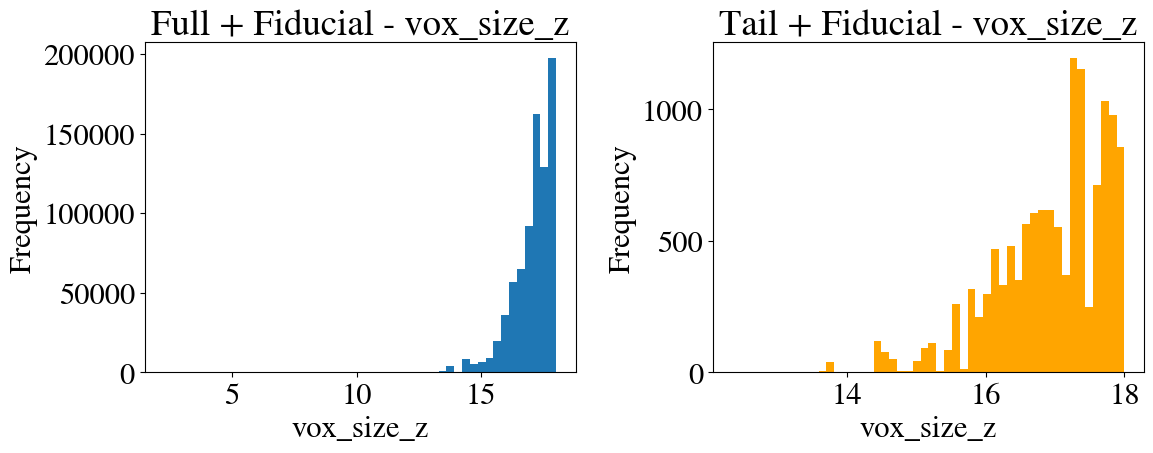

In [64]:
for traits in tail_hdst.columns.values:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].hist(cut_hdst[traits].values, bins=50, range=(cut_hdst[traits].min(), cut_hdst[traits].max()))
    axs[0].set_title(f'Full + Fiducial - {traits}')
    
    axs[1].hist(cut_tail_hdst[traits].values, bins=50, range=(cut_tail_hdst[traits].min(), cut_tail_hdst[traits].max()), color = 'orange')
    axs[1].set_title(f'Tail + Fiducial - {traits}')
    
    for ax in axs:
        ax.set_xlabel(traits)
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()